# Holt-Winter's Exponential Smoothing

References for HWES codes:

Filho, M. (2023, July 12). How To Do Time Series Cross-Validation in Python. Forecastegy. https://forecastegy.com/posts/time-series-cross-validation-python/

Khan, E. (2021, Jan 5). Python Code on Holt-Winters Forecasting. Medium. https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

statsmodels.tsa.holtwinters.ExponentialSmoothing. (2024, Oct 3). statsmodels. https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

Given the stock information of at least the past 5 days of one particular company, try to predict the closing price of that company on a particular day

Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

Load training set and process date to ensure it is parseable

In [2]:
# Load the dataset
train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", train_data.columns)
print(train_data.head())

# Convert 'Date' to datetime, handling errors
train_data['Date'] = pd.to_datetime(train_data['Date'], errors='coerce')

# Check for NaT values after conversion
if train_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(train_data[train_data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2020-09-30  100.940002  1362200      A                       14.0   
1  2020-10-01  101.220001   723600      A                        0.0   
2  2020-10-02  100.010002   712200      A                        0.0   
3  2020-10-05  103.120003   803900      A                 

C:\Users\Admin\AppData\Local\Temp\ipykernel_25712\2972640794.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


Define your company of interest and obtain its closing price for the days in training set (n>= 5)

In [3]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
company = 'MMM' 

# Filter data for the specific company
company_data = train_data[train_data['Symbol'] == company]

# Check if company is in dataset
if company_data.empty:
    raise ValueError(f"No data found for company: {company}")

# Set the 'Date' column as the index
company_data.set_index('Date', inplace=True)

# Ensure we have at least 5 days of data
if len(company_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# train n days for modeling - we will use entire length of training set
train_n_days = company_data['Close']

# Ensure 'train_n_days' is not empty
if train_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

Perform Rolling-window Cross Validation

In [4]:
# Define rolling window parameters
n = len(train_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1


library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are additive or multiplicative

In [5]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = train_n_days.iloc[:train_size + start]
    test = train_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast) 
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.266823
1   add      mul  1.267996
2   mul      add  1.267100
3   mul      mul  1.267164
Lowest RMSE: 1.2668226851080036
Trend: add, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Us

Input the trend and seasonality, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [6]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    train_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7
).fit()

print(model.summary())

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                           1437.737
Optimized:                         True   AIC                            501.280
Trend:                         Additive   BIC                            542.628
Seasonal:                      Additive   AICC                           502.481
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:04:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9718336                alpha                 True
smoothing_trend          

Visualise Holt-Winter's smoothed values and actual values and calculate in-sample RMSE and MAPE

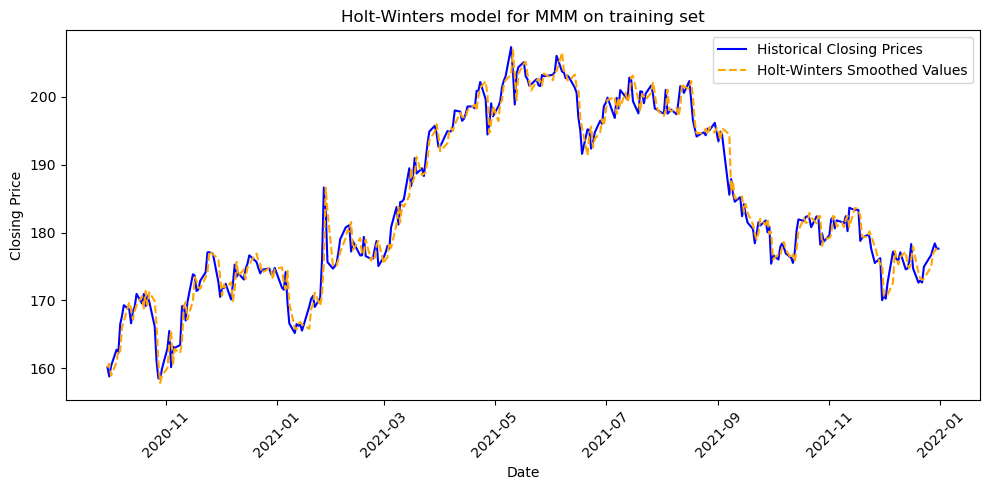

Predicted Closing Price for MMM on the next day: 178.15518978879842
RMSE between smoothed values and historical closing prices: 1.2668226851080036
MAPE between smoothed values and historical closing prices: 0.867%


In [7]:
# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not train entire training set
historical_m_data = company_data['Close'][:]  
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model for {company} on training set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and this model's RMSE and MAPE
print(f'Predicted Closing Price for {company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between smoothed values and historical closing prices: {lowest_rmse_row['rmse']}")
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(train_n_days.values) - np.array(smoothed_values.values)) / np.array(train_n_days.values))) * 100
print(f'MAPE between smoothed values and historical closing prices: {mape:.3f}%')


Forecast using model above and compare against data in TEST set

In [8]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", test_data.columns)
print(test_data.head())

# Convert 'Date' to datetime, handling errors
test_data['Date'] = pd.to_datetime(test_data['Date'], errors='coerce')

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2022-01-03  156.479996  1606300      A                        0.0   
1  2022-01-04  151.190002  2234000      A                        0.0   
2  2022-01-05  148.600006  2370500      A                        0.0   
3  2022-01-06  149.119995  2298300      A                 

Make one-time forecast, plot against actual values and calculate the out-of-sample RMSE and MAPE

Date
2022-01-03    177.746721
2022-01-04    178.288537
2022-01-05    178.343158
2022-01-06    178.583250
2022-01-07    178.268219
                 ...    
2022-06-24    184.192707
2022-06-27    184.734523
2022-06-28    184.789145
2022-06-29    185.029236
2022-06-30    184.714205
Length: 124, dtype: float64


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


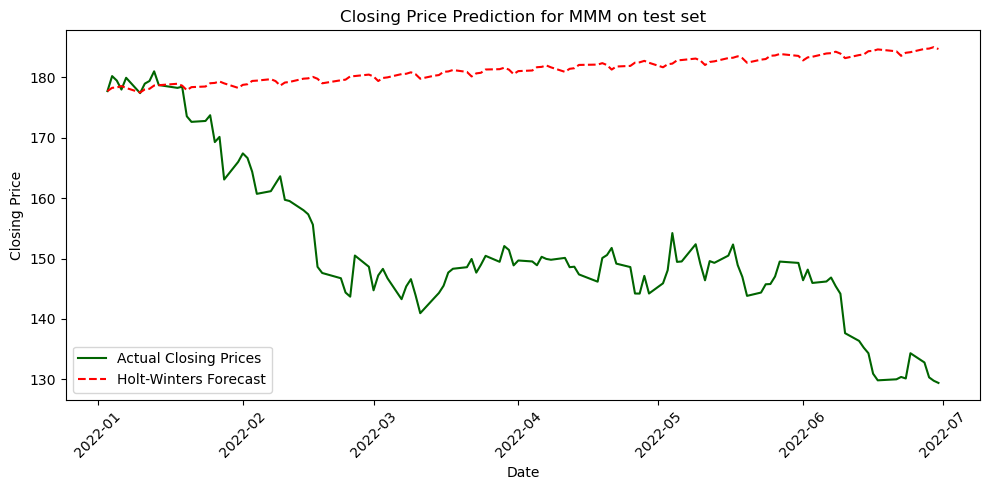

Predicted Closing Price for MMM on the next day: 177.74672104906853
RMSE between forecast values and actual closing prices: 32.82129716061761
MAPE between forecast values and actual closing prices: 20.408%


In [9]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_company ='MMM'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Forecast target company's closing price for the length of test set
forecast = model.forecast(steps=len(test_company_data))

# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not choose entire test set
test_historical_m_data = test_company_data['Close']

# Align predicted values with the test data index
forecast.index = test_historical_m_data.index

# Print the predicted values
print(forecast)

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(forecast.values, test_historical_m_data.values)

# Calculate MAPE
test_mape = np.mean(np.abs((np.array(forecast.values) - np.array(test_historical_m_data.values)) / np.array(test_historical_m_data.values))) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.3f}%')

Combine both plots to visualise how the model fitted the training data and forecasted against the test data

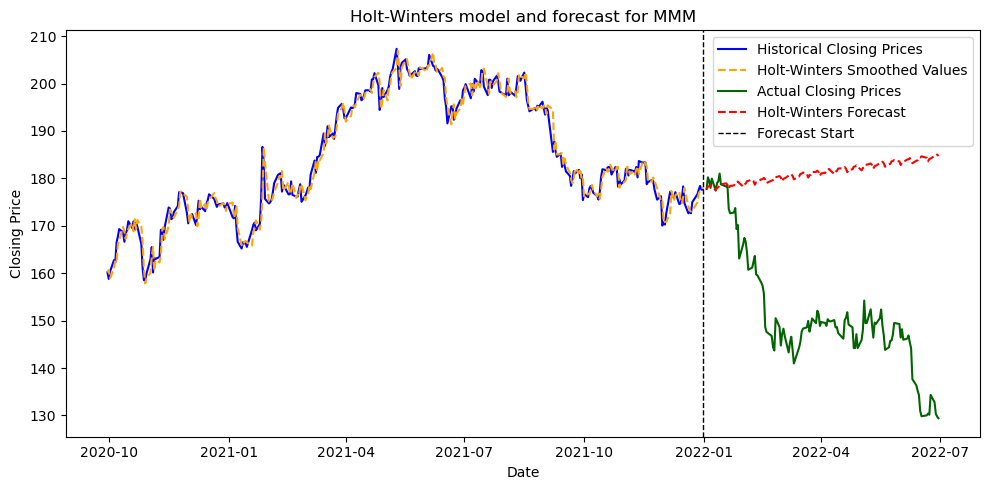

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
hw_mape_dict = {'MMM':20.408, 'XOM':20.176, 'SHW':46.053, 'AMZN':22.950, 'PG':10.982, 'JNJ':2.193, 'JPM':27.188, 'AAPL':19.832, 'GOOGL':25.370, 'NEE':26.247, 'AMT':22.516}

hw_mape_mean = sum(hw_mape_dict.values()) / len(hw_mape_dict.values())  
print(f"Mean of MAPE values: {hw_mape_mean:.3f}%")

Mean of MAPE values: 22.174%


Rolling Forecast Origin

a more responsive forecasting method compared to traditional one-time forecasting technique above

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  440
Model:             ExponentialSmoothing   SSE                           2108.277
Optimized:                         True   AIC                            711.415
Trend:                         Additive   BIC                            756.369
Seasonal:                      Additive   AICC                           712.269
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:04:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9382674                alpha                 True
smoothing_trend          

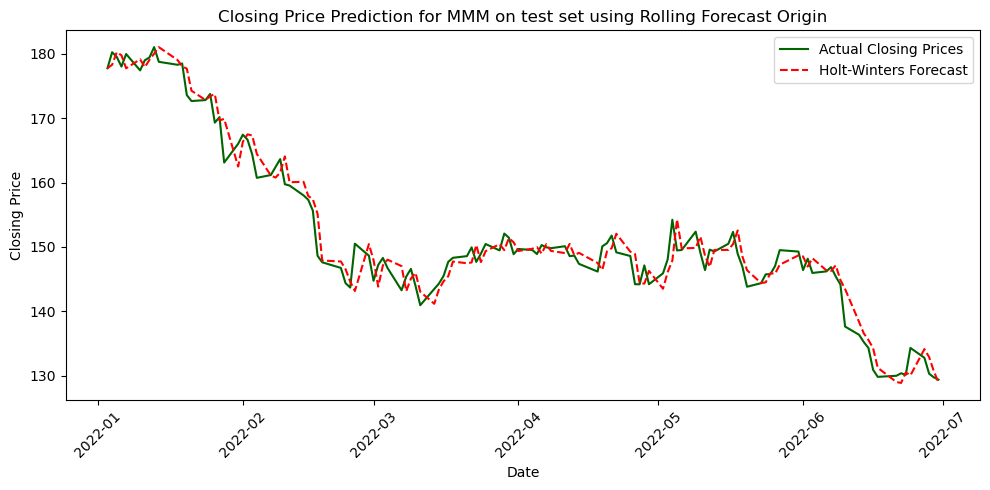

Predicted Closing Price for MMM on the next day: 177.74672104906853
RMSE between forecast values and actual closing prices: 2.357546992577983
MAPE between forecast values and actual closing prices: 1.2187%


In [12]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest 
test_company = 'MMM'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Pre-existing training data from above
train_n_days = company_data['Close']

# Prepare to store forecasts and actual values
forecasts = []
actual_values = []

# Start rolling forecast from the last day of the train set
for i in range(len(test_company_data)):
    # Combine the training data with the current test data point
    combined_data = pd.concat([train_n_days, test_company_data['Close'][:i-1 + 1]])
    
    # Fit the Holt-Winters model
    model = ExponentialSmoothing(combined_data, trend=lowest_trend, seasonal=lowest_seasonal, seasonal_periods=7)
    model_fit = model.fit(optimized=True)
    
    # Forecast the next value
    forecast = model_fit.forecast(steps=1)
    forecasts.append(forecast.values[0])
    actual_values.append(test_company_data['Close'].iloc[i])

print(model_fit.summary())

# Align predicted values with the test data index for visualisation
forecast_index = test_company_data.index
forecast_series = pd.Series(forecasts, index=forecast_index)

# Calculate RMSE and MAPE
test_rmse = root_mean_squared_error(actual_values, forecasts)
test_mape = np.mean(np.abs((np.array(actual_values) - np.array(forecasts)) / np.array(actual_values))) * 100

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast_series.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.4f}%')


Combine the two plots again to see the complete graph of how the model fits the training data and forecasts against test data, using Rolling Forecast Origin this time round

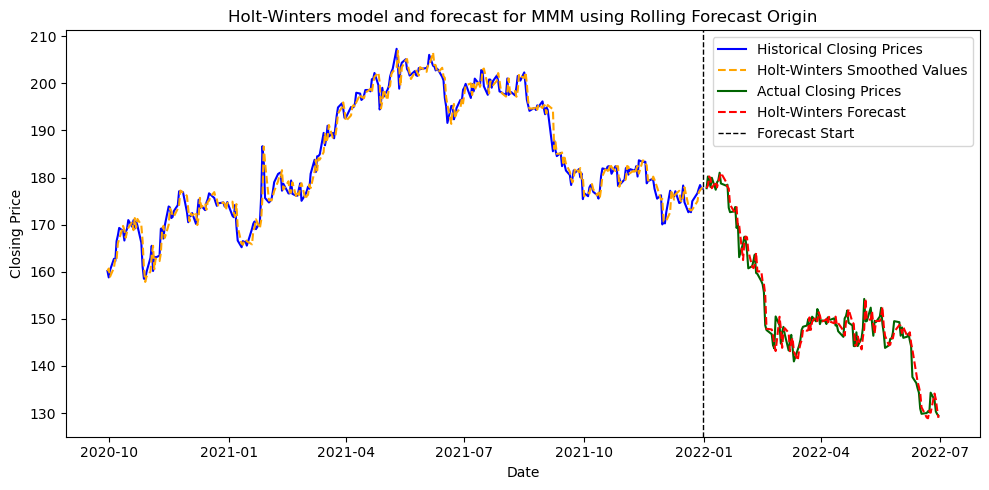

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {company} using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
hw_mape_rfo_dict = {'MMM':1.2187, 'XOM':1.8773, 'SHW':1.7406, 'AMZN':2.5600, 'PG':1.1666, 'JNJ':0.9409, 'JPM':1.6110, 'AAPL':1.8110, 'GOOGL':1.0430, 'NEE':1.5474, 'AMT':1.5875}

hw_mape_rfo_mean = sum(hw_mape_rfo_dict.values()) / len(hw_mape_rfo_dict.values())  
print(f"Mean of rolling forecast origin MAPE values: {hw_mape_rfo_mean:.3f}%")

Mean of rolling forecast origin MAPE values: 1.555%


Given the stock information of at least the past 5 days of all companies, try to predict the closing price of one company on a particular day

some companies in training set and some companies only in test set

Load libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

Load training set and process Date

In [16]:
# Load the dataset
train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")

# Convert 'Date' to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Check for NaT values after conversion
if train_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(train_data[train_data['Date'].isnull()])

C:\Users\Admin\AppData\Local\Temp\ipykernel_25712\3966680002.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


Training set= companies belonging in the same industry as target company, but excluding target company (test set)

Define your company of interest and obtain the average closing price for the days in training set (n>= 5)

In [17]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
target_company = 'MMM'

# Ensure we have data for the target company
if target_company not in train_data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = train_data[train_data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
target_industry = target_data['GICS Sector'].iloc[0]
print(target_industry)

# Filter data for companies in the same industry, excluding the target company
industry_data = train_data[(train_data['GICS Sector'] == target_industry) & (train_data['Symbol'] != target_company)]

# # YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# Train n days for modeling - we will use entire length of training set
train_n_days_target = target_data['Close']

# Train n days of data for all companies in the same industry excluding the target company
train_n_days_industry = industry_data[industry_data['Date'].isin(train_n_days_target.index)]

# Calculate the average closing price for the last n days, excluding the target company
avg_train_n_days = train_n_days_industry.groupby('Date')['Close'].mean()


Industrials


Perform rolling-window cross validation

In [18]:
# Define rolling window parameters
n = len(avg_train_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1

library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are additive or multiplicative

In [19]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_train_n_days.iloc[:train_size + start]
    test = avg_train_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.349795
1   add      mul  1.354288
2   mul      add  1.348974
3   mul      mul  1.354702
Lowest RMSE: 1.3489735400451357
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Input the trend and seasonality, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [20]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_train_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                            888.415
Optimized:                         True   AIC                            348.680
Trend:                   Multiplicative   BIC                            390.028
Seasonal:                      Additive   AICC                           349.882
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:04:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9590170                alpha                 True
smoothing_trend          

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Visualise Holt-Winter's smoothed values and actual values and calculate in-sample RMSE and MAPE

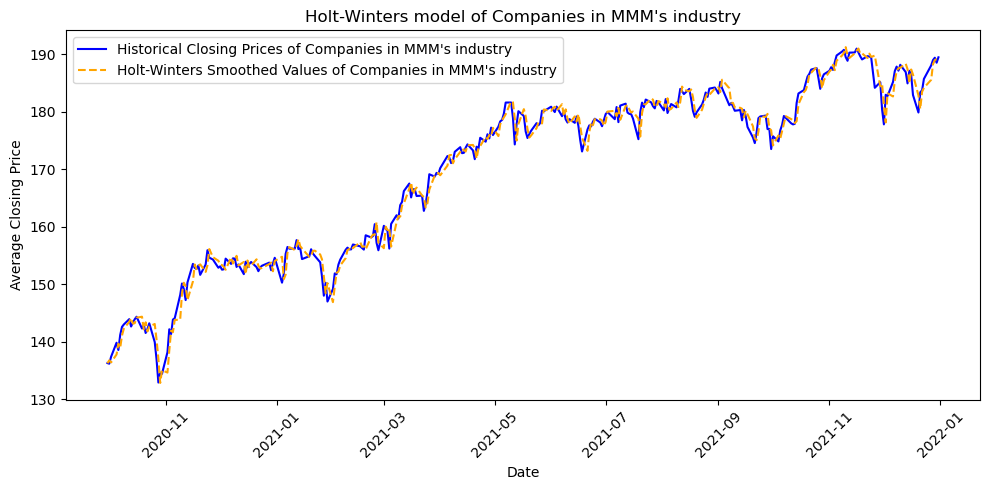

Predicted Average Closing Price for Companies in MMM's industry on the next day: 189.09423112176748
RMSE between smoothed values and historical closing prices: 1.6740883322406683
MAPE between smoothed values and historical closing prices: 0.7767%


In [21]:
# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(avg_train_n_days.index, avg_train_n_days, label=f"Historical Closing Prices of Companies in {target_company}'s industry", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.title(f"Holt-Winters model of Companies in {target_company}'s industry")
plt.xlabel('Date')
plt.ylabel('Average Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f"Predicted Average Closing Price for Companies in {target_company}'s industry on the next day: {forecast.iloc[0]}")

# Calcualte RMSE between actual values and smoothed values
rmse = root_mean_squared_error(avg_train_n_days.values, smoothed_values.values)
print(f"RMSE between smoothed values and historical closing prices: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((avg_train_n_days.values - smoothed_values.values) / avg_train_n_days.values)) * 100
print(f'MAPE between smoothed values and historical closing prices: {mape:.4f}%')


Forecast using model above and compare against data in TEST set (the target company)

In [22]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

Make one-time forecast, plot against actual values and calculate the out-of-sample RMSE and MAPE

Date
2022-01-03    189.657489
2022-01-04    190.105665
2022-01-05    190.019169
2022-01-06    190.329804
2022-01-07    190.355127
                 ...    
2022-06-24    209.858670
2022-06-27    210.311464
2022-06-28    210.229586
2022-06-29    210.544841
2022-06-30    210.574784
Length: 124, dtype: float64


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


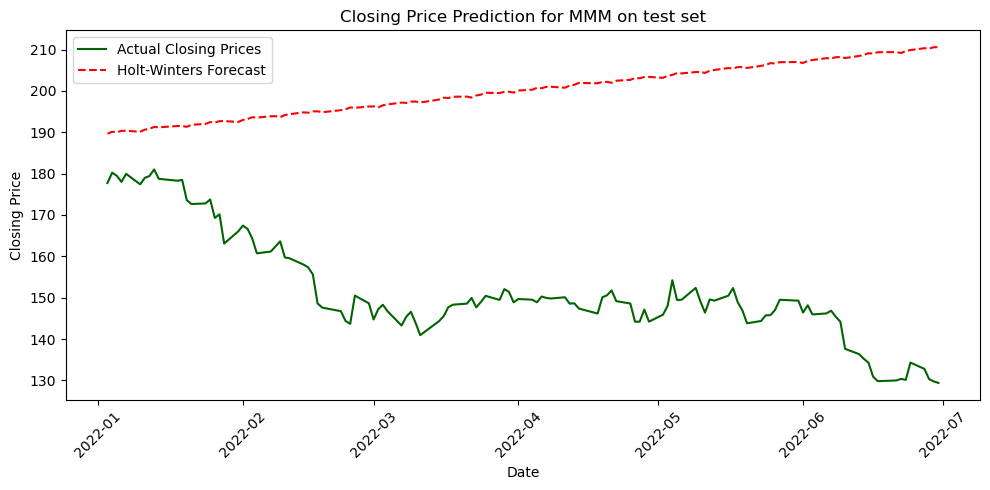

Predicted Closing Price for MMM on the next day: 189.657489402048
RMSE between forecast values and actual closing prices: 51.56321668047141
MAPE between forecast values and actual closing prices: 32.967%


In [23]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_target_company = 'MMM'

# Ensure company is in the dataset
if test_target_company not in test_data['Symbol'].unique():
    raise ValueError(f"{test_target_company} is not in the dataset.")

# Filter data for the target company and set 'Date' column as index
test_target_data = test_data[test_data['Symbol'] == test_target_company].set_index('Date')

# Ensure we have at least 5 days of data
if len(test_target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Forecast target company's closing price for the length of test set
forecast = model.forecast(steps=len(test_target_data))

# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not choose entire test set
test_historical_m_data = test_target_data['Close']

# Align predicted values with the test data index
forecast.index = test_historical_m_data.index

# Print the predicted values
print(forecast)

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(forecast.values, test_historical_m_data.values)

# Calculate MAPE
test_mape = np.mean(np.abs((np.array(forecast.values) - np.array(test_historical_m_data.values)) / np.array(test_historical_m_data.values))) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_target_company} on test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_target_company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.3f}%')



Combine both plots to visualise how the model fitted the training data and forecasted against the test data

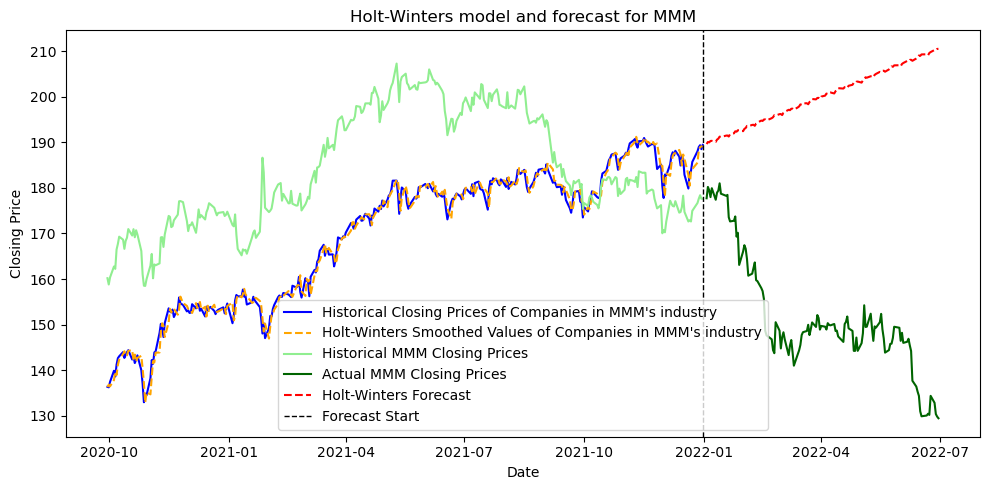

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_n_days.index, avg_train_n_days, label=f"Historical Closing Prices of Companies in {target_company}'s industry", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label=f"Holt-Winters Smoothed Values of Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {target_company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train_n_days_target.index, train_n_days_target, label=f'Historical {target_company} Closing Prices', color='lightgreen')
plt.plot(test_historical_m_data.index, test_historical_m_data, label=f'Actual {target_company} Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=avg_train_n_days.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

Rolling Forecast Origin - test data of the target company is slowly added to training data (average Close prices of the related companies in training period)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  440
Model:             ExponentialSmoothing   SSE                           1708.500
Optimized:                         True   AIC                            618.902
Trend:                   Multiplicative   BIC                            663.857
Seasonal:                      Additive   AICC                           619.757
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:05:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9146411                alpha                 True
smoothing_trend          

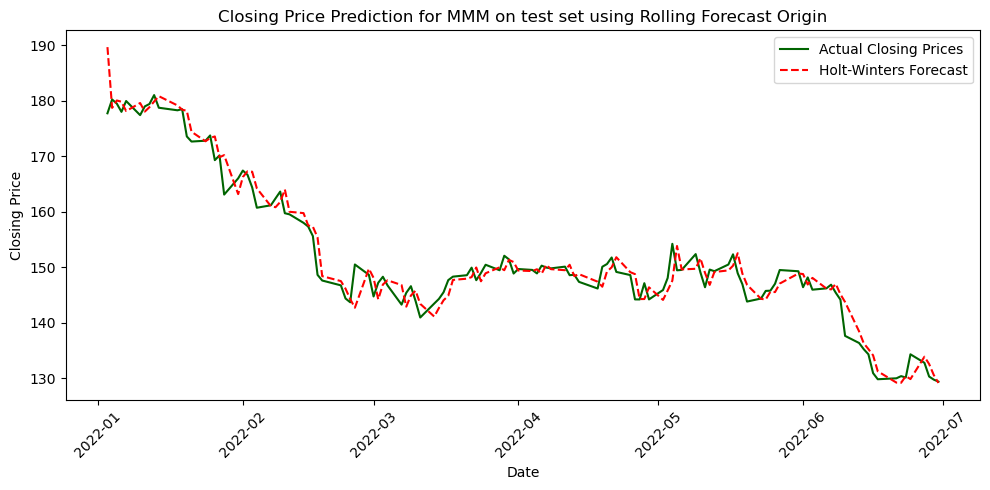

Predicted Closing Price for MMM on the next day: 189.657489402048
RMSE between forecast values and actual closing prices: 2.5993169887169287
MAPE between forecast values and actual closing prices: 1.2556%


In [25]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest 
test_company = 'MMM'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Pre-existing training data from above
# avg_train_n_days 

# Prepare to store forecasts and actual values
forecasts = []
actual_values = []

# Start rolling forecast from the last day of training set
for i in range(len(test_company_data)):
    # Combine the training data with the current test data point
    combined_data = pd.concat([avg_train_n_days, test_company_data['Close'][:i-1 + 1]])
    
    # Fit the Holt-Winters model
    model = ExponentialSmoothing(combined_data, trend=lowest_trend, seasonal=lowest_seasonal, seasonal_periods=7)
    model_fit = model.fit(optimized=True)
    
    # Forecast the next value
    forecast = model_fit.forecast(steps=1)
    forecasts.append(forecast.values[0])
    actual_values.append(test_company_data['Close'].iloc[i])

print(model_fit.summary())

# Align predicted values with the test data index for visualisation
forecast_index = test_company_data.index
forecast_series = pd.Series(forecasts, index=forecast_index)

# Calculate RMSE and MAPE
test_rmse = root_mean_squared_error(actual_values, forecasts)
test_mape = np.mean(np.abs((np.array(actual_values) - np.array(forecasts)) / np.array(actual_values))) * 100

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast_series.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.4f}%')

All companies in training set and all companies in test set

Training set= all S&P 500 companies, including target company

Define your company of interest and obtain the average closing price for the days in training set (n>= 5)

In [26]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
target_company = 'MMM'

# Ensure we have data for the target company
if target_company not in train_data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = train_data[train_data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# Train n days for modeling - we will use entire length of training set
train_n_days_target = target_data['Close']

# Get the last n days of data for all companies in the dataset
train_n_days_all = train_data[train_data['Date'].isin(train_n_days_target.index)]

# Calculate the average closing price for the last n days for all companies including the target company
avg_train_n_days_all = train_n_days_all.groupby('Date')['Close'].mean()


Perform rolling-window cross validation

In [27]:
# Define rolling window parameters
n = len(avg_train_n_days_all)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

In [28]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_train_n_days_all.iloc[:train_size + start]
    test = avg_train_n_days_all.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.482946
1   add      mul  1.493265
2   mul      add  1.481911
3   mul      mul  1.489159
Lowest RMSE: 1.4819105323029511
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Input the trend and seasonality, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [29]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_train_n_days_all,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                            829.291
Optimized:                         True   AIC                            326.849
Trend:                   Multiplicative   BIC                            368.197
Seasonal:                      Additive   AICC                           328.050
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:05:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9556761                alpha                 True
smoothing_trend          

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Visualise Holt-Winter's smoothed values and actual values and calculate in-sample RMSE and MAPE

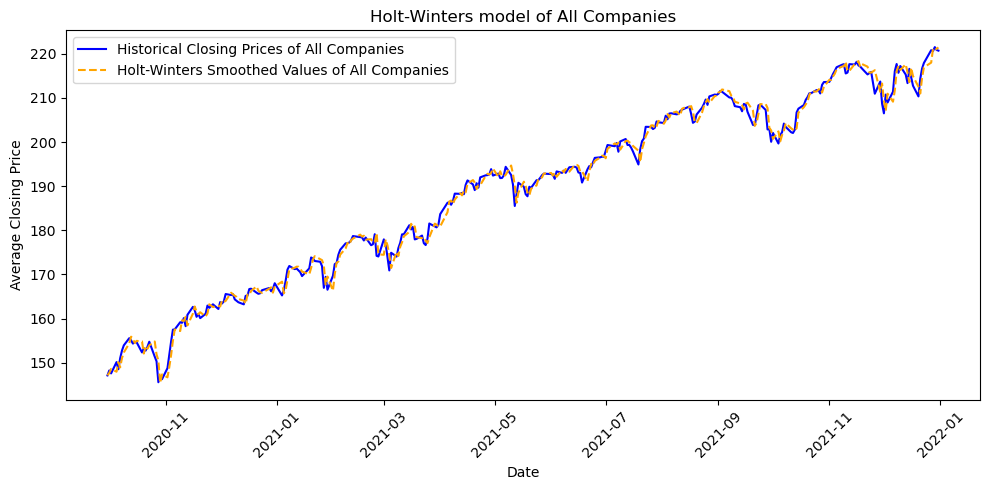

Predicted Average Closing Price for All Companies on the next day: 221.54173911827613
RMSE between smoothed values and actual closing prices: 1.61742344482224
MAPE between smoothed values and actual closing prices: 0.6682%


In [30]:
# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(avg_train_n_days_all.index, avg_train_n_days_all, label=f"Historical Closing Prices of All Companies", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies", color='orange', linestyle='--')
plt.title(f"Holt-Winters model of All Companies")
plt.xlabel('Date')
plt.ylabel('Average Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f"Predicted Average Closing Price for All Companies on the next day: {forecast.iloc[0]}")

# Calcualte RMSE between actual values and smoothed values
rmse = root_mean_squared_error(avg_train_n_days_all.values, smoothed_values.values)
print(f"RMSE between smoothed values and actual closing prices: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((avg_train_n_days_all.values - smoothed_values.values) / avg_train_n_days_all.values)) * 100
print(f'MAPE between smoothed values and actual closing prices: {mape:.4f}%')


Forecast using model above and compare against data in TEST set

In [31]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])


Make one-time forecast, plot against actual values and calculate the out-of-sample RMSE and MAPE

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-01-03    221.160990
2022-01-04    221.527446
2022-01-05    221.649302
2022-01-06    222.038568
2022-01-07    222.212675
                 ...    
2022-06-24    250.614301
2022-06-27    250.994179
2022-06-28    251.129462
2022-06-29    251.532162
2022-06-30    251.719710
Length: 124, dtype: float64


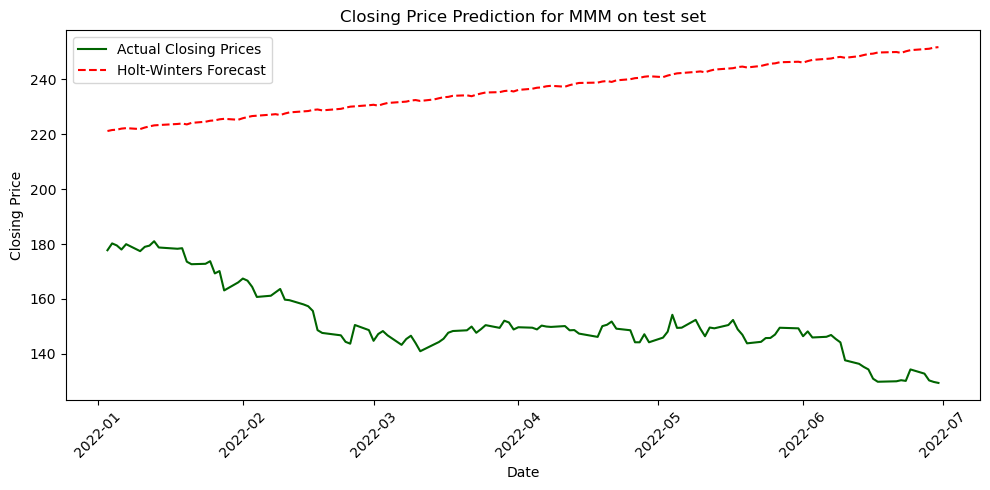

Predicted Closing Price for MMM on the next day: 221.16098950357951
RMSE between forecast values and actual closing prices: 86.92553628031966
MAPE between forecast values and actual closing prices: 57.065%


In [32]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_target_company = 'MMM'

# Ensure company is in the dataset
if test_target_company not in test_data['Symbol'].unique():
    raise ValueError(f"{test_target_company} is not in the dataset.")

# Filter data for the target company and set 'Date' column as index
test_target_data = test_data[test_data['Symbol'] == test_target_company].set_index('Date')

# Ensure we have at least 5 days of data
if len(test_target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Forecast target company's closing price for the length of test set
forecast = model.forecast(steps=len(test_target_data))

# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not choose entire test set
test_historical_m_data = test_target_data['Close']

# Align predicted values with the test data index
forecast.index = test_historical_m_data.index

# Print the predicted values
print(forecast)

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(forecast.values, test_historical_m_data.values)

# Calculate MAPE
test_mape = np.mean(np.abs((np.array(forecast.values) - np.array(test_historical_m_data.values)) / np.array(test_historical_m_data.values))) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_target_company} on test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_target_company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.3f}%')

Combine both plots to visualise how the model fitted the training data and forecasted against the test data

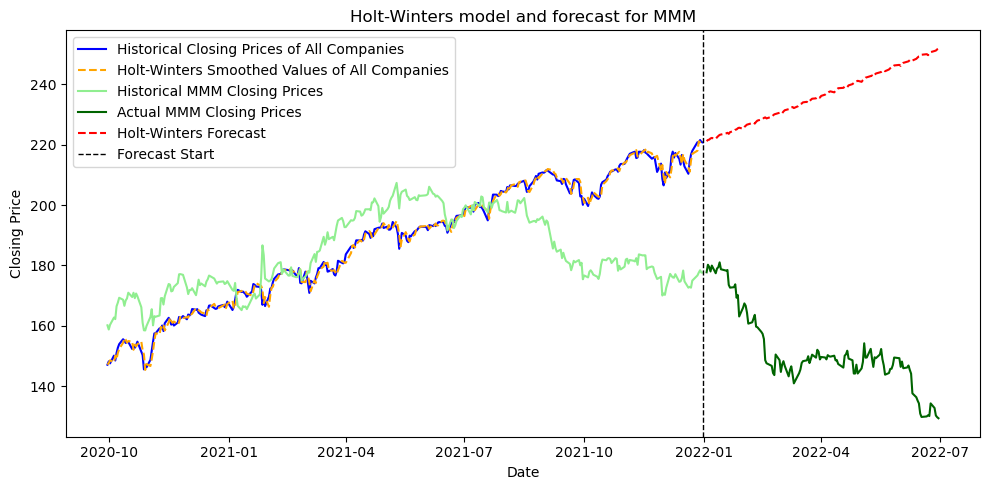

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_n_days_all.index, avg_train_n_days_all, label="Historical Closing Prices of All Companies", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label=f"Holt-Winters Smoothed Values of All Companies", color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {target_company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train_n_days_target.index, train_n_days_target, label=f'Historical {target_company} Closing Prices', color='lightgreen')
plt.plot(test_historical_m_data.index, test_historical_m_data, label=f'Actual {target_company} Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=avg_train_n_days_all.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

Rolling Forecast Origin - test data of target data is slowly added to training data (average Close prices of all S&P 500 companies in training period)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  440
Model:             ExponentialSmoothing   SSE                           3363.856
Optimized:                         True   AIC                            916.990
Trend:                   Multiplicative   BIC                            961.945
Seasonal:                      Additive   AICC                           917.845
Seasonal Periods:                     7   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         14:07:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9429211                alpha                 True
smoothing_trend          

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


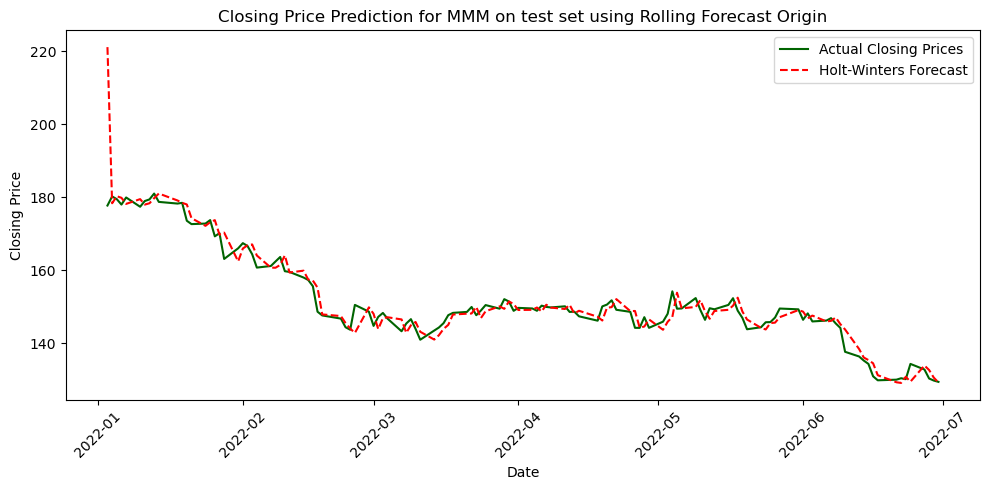

Predicted Closing Price for MMM on the next day: 221.16098950357951
RMSE between forecast values and actual closing prices: 4.581106734365411
MAPE between forecast values and actual closing prices: 1.4174%


In [35]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest 
test_company = 'MMM'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Pre-existing training data from above
# avg_train_n_days_all 

# Prepare to store forecasts and actual values
forecasts = []
actual_values = []

# Start rolling forecast from the last day of training set
for i in range(len(test_company_data)):
    # Combine the training data with the current test data point
    combined_data = pd.concat([avg_train_n_days_all, test_company_data['Close'][:i-1 + 1]])
    
    # Fit the Holt-Winters model
    model = ExponentialSmoothing(combined_data, trend=lowest_trend, seasonal=lowest_seasonal, seasonal_periods=7)
    model_fit = model.fit(optimized=True)
    
    # Forecast the next value
    forecast = model_fit.forecast(steps=1)
    forecasts.append(forecast.values[0])
    actual_values.append(test_company_data['Close'].iloc[i])

print(model_fit.summary())

# Align predicted values with the test data index for visualisation
forecast_index = test_company_data.index
forecast_series = pd.Series(forecasts, index=forecast_index)

# Calculate RMSE and MAPE
test_rmse = root_mean_squared_error(actual_values, forecasts)
test_mape = np.mean(np.abs((np.array(actual_values) - np.array(forecasts)) / np.array(actual_values))) * 100

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast_series.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.4f}%')

# Long Short-Term Memory Neural Network

Sources referred to for codes:

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.

This paper is the original introduction to Long Short-Term Memory (LSTM) networks, describing the architecture and benefits of using LSTM for handling long-term dependencies in sequential data.
Graves, A., Mohamed, A. R., & Hinton, G. (2013). Speech recognition with deep recurrent neural networks. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 6645-6649). IEEE.

This work demonstrates LSTM applications in deep neural networks, particularly for sequential data like speech, and provides insights into tuning LSTM for complex time series tasks.
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

This foundational paper introduces the concept of attention mechanisms, which are now commonly incorporated into LSTM-based models to improve focus on relevant parts of sequences.
Brownlee, J. (2018). Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery.

Brownlee provides practical implementations of LSTM models for time series forecasting, including methods for creating input sequences and tuning LSTM parameters. Available at Machine Learning Mastery.
Chollet, F. (2015). Keras. GitHub repository. https://github.com/fchollet/keras

Keras documentation and example codes are essential resources for building LSTM models in Python. The Keras repository includes examples of LSTM architectures for various applications.
Graves, A. (2012). Supervised sequence labelling with recurrent neural networks. In Studies in Computational Intelligence, Vol. 385. Springer, Berlin, Heidelberg.

This book covers practical applications of LSTM and other recurrent neural networks, including code and explanations on sequence modeling and handling time series data.
Pytorch Team. (2019). PyTorch Documentation. https://pytorch.org/docs/stable/index.html

The official PyTorch documentation provides extensive examples and best practices for implementing LSTM models, including tutorials on sequence modeling and time series forecasting with LSTM and attention layers.

One-time prediction applied on LSTM model for MMM prediction 

C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:18: SettingWithC

Epoch 1/150 - MMM - Training Loss: 0.0292, Validation Loss: 0.0487
Epoch 2/150 - MMM - Training Loss: 0.0030, Validation Loss: 0.0178
Epoch 3/150 - MMM - Training Loss: 0.0239, Validation Loss: 0.0151
Epoch 4/150 - MMM - Training Loss: 0.1969, Validation Loss: 0.0936
Epoch 5/150 - MMM - Training Loss: 0.1328, Validation Loss: 0.0605
Epoch 6/150 - MMM - Training Loss: 0.1508, Validation Loss: 0.0709
Epoch 7/150 - MMM - Training Loss: 0.1411, Validation Loss: 0.0635
Epoch 8/150 - MMM - Training Loss: 0.1395, Validation Loss: 0.0656
Epoch 9/150 - MMM - Training Loss: 0.1451, Validation Loss: 0.0673
Epoch 10/150 - MMM - Training Loss: 0.1411, Validation Loss: 0.0649
Epoch 11/150 - MMM - Training Loss: 0.1391, Validation Loss: 0.0635
Epoch 12/150 - MMM - Training Loss: 0.1372, Validation Loss: 0.0634
Epoch 13/150 - MMM - Training Loss: 0.1374, Validation Loss: 0.0632
Early stopping triggered for MMM

MMM - One-Time Prediction Results:
Mean Squared Error (MSE): 318.6568077717322
Root Mean Sq

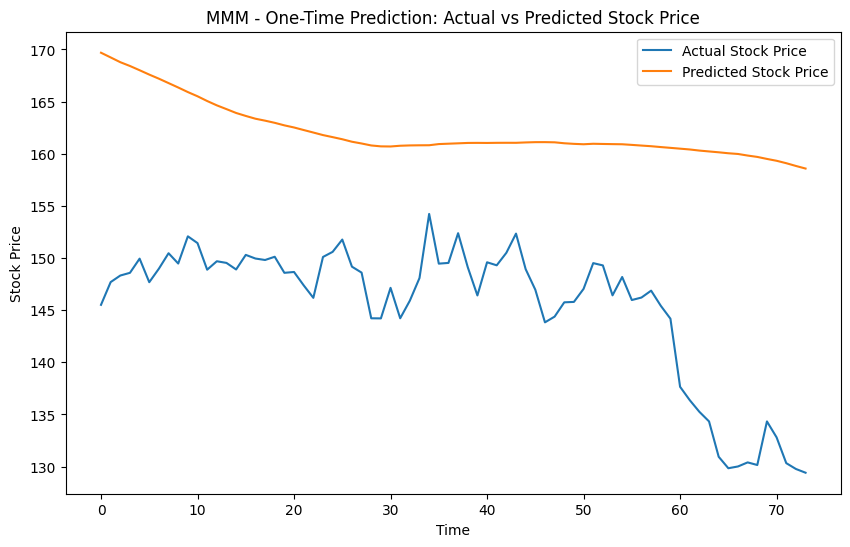

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Filter data for "MMM" ticker only
data_filtered = data[data['Symbol'] == "MMM"]

# Feature engineering
data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()  # 30-day moving average
data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                               'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                               'Close_MA7', 'Close_MA30']].dropna()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filtered)

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and validation sets
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Initialize the model, loss function, and optimizer
input_size = data_filtered.shape[1]
model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping setup
min_val_loss = np.inf
early_stop_counter = 0

# Training loop
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()
        y_pred_val = model(X_val_tensor)
        val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
    
    print(f"Epoch {epoch+1}/{epochs} - MMM - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
    
    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping triggered for MMM")
            break

# One-time prediction on the validation set
model.eval()
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).float()
    y_pred_val = model(X_val_tensor).squeeze().numpy()

# Rescale and evaluate
actual_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
predicted_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_pred_val.reshape(-1, 1), np.zeros((len(y_pred_val), input_size - 1))], axis=1))[:, 0])

# Calculate error metrics
mse = mean_squared_error(actual_values_rescaled, predicted_values_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values_rescaled - predicted_values_rescaled) / actual_values_rescaled)) * 100

# Print results
print(f"\nMMM - One-Time Prediction Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the actual and predicted stock prices for "MMM"
plt.figure(figsize=(10, 6))
plt.plot(actual_values_rescaled, label='Actual Stock Price')
plt.plot(predicted_values_rescaled, label='Predicted Stock Price')
plt.title('MMM - One-Time Prediction: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Rolling forecast applied on LSTM model for MMM prediction

C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:18: SettingWithC

Epoch 1/150, Training Loss: 0.040658120065927505, Validation Loss: 0.057664334774017334
Epoch 2/150, Training Loss: 0.01851104386150837, Validation Loss: 0.033004771918058395
Epoch 3/150, Training Loss: 0.000699445663485676, Validation Loss: 0.009731709957122803
Epoch 4/150, Training Loss: 0.06429756432771683, Validation Loss: 0.030810894444584846
Epoch 5/150, Training Loss: 0.049237363040447235, Validation Loss: 0.026280242949724197
Epoch 6/150, Training Loss: 0.056491654366254807, Validation Loss: 0.03005434386432171
Epoch 7/150, Training Loss: 0.04699953645467758, Validation Loss: 0.025979219004511833
Epoch 8/150, Training Loss: 0.05473756045103073, Validation Loss: 0.03130904585123062
Epoch 9/150, Training Loss: 0.045939646661281586, Validation Loss: 0.026650864630937576
Epoch 10/150, Training Loss: 0.0497482605278492, Validation Loss: 0.02863875962793827
Epoch 11/150, Training Loss: 0.04500021040439606, Validation Loss: 0.026113705709576607
Epoch 12/150, Training Loss: 0.046276152

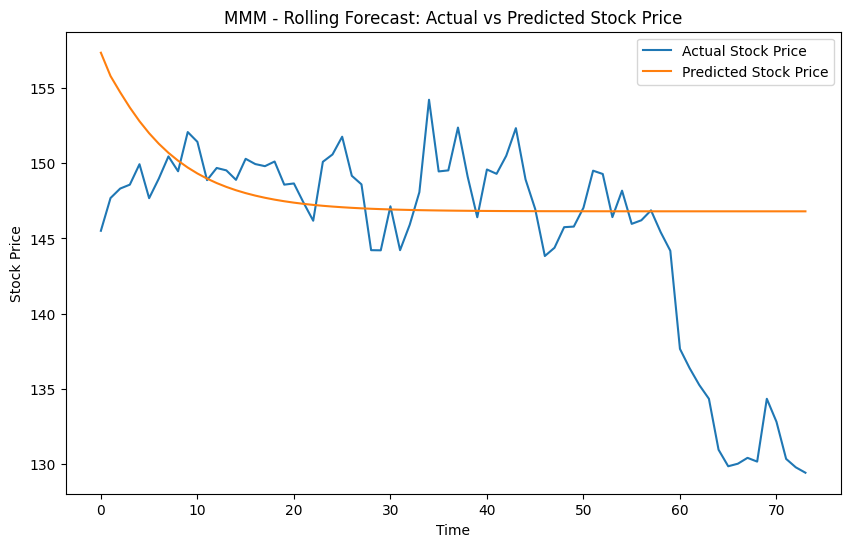

Mean Squared Error (MSE): 49.90376120152307
Root Mean Squared Error (RMSE): 7.064259423430249
Mean Absolute Percentage Error (MAPE): 3.407548655140803%


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Filter data for "MMM" ticker only
data_filtered = data[data['Symbol'] == "MMM"]

# Select relevant columns and add additional feature engineering
data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()  # 30-day moving average
data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                               'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                               'Close_MA7', 'Close_MA30']].dropna()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filtered)

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameter adjustments
sequence_length = 45  # Adjusted sequence length
hidden_layer_size = 384  # Adjusted hidden layer size
num_layers = 1  # Simplified to 1 layer
dropout_rate = 0.2
learning_rate = 0.00005  # Slightly higher learning rate
batch_size = 16  # Increased batch size

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and validation sets
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Define Simplified Bidirectional LSTM Model
class SimpleBidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=hidden_layer_size, output_size=1, num_layers=num_layers):
        super(SimpleBidirectionalLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.bidirectional_lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, 
                                          dropout=dropout_rate, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        
        lstm_out, _ = self.bidirectional_lstm(x, (h_0, c_0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Instantiate and train the model
input_size = data_filtered.shape[1]
model = SimpleBidirectionalLSTM(input_size=input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Implement early stopping
early_stopping_patience = 10
min_val_loss = np.inf
early_stop_counter = 0

# Training loop with increased epochs
epochs = 150
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()
        y_pred_val = model(X_val_tensor)
        val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
    
    # Print losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
    
    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Rolling forecast on validation data
model.eval()
rolling_predictions = []
current_sequence = X_val[0]  # Start with the first sequence in validation data

with torch.no_grad():
    for i in range(len(X_val)):
        current_sequence_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0)
        prediction = model(current_sequence_tensor)
        rolling_predictions.append(prediction.item())

        # Update sequence by appending the prediction and removing the oldest element
        new_prediction = np.array([[prediction.item()] + [0] * (current_sequence.shape[1] - 1)])
        new_sequence = np.vstack((current_sequence[1:], new_prediction))
        current_sequence = new_sequence

# Rescale and evaluate, converting back from log scale
actual_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
rolling_predictions_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([np.array(rolling_predictions).reshape(-1, 1), np.zeros((len(rolling_predictions), input_size - 1))], axis=1))[:, 0])

# Plot the actual and predicted stock prices for "MMM"
plt.figure(figsize=(10, 6))
plt.plot(actual_values_rescaled, label='Actual Stock Price')
plt.plot(rolling_predictions_rescaled, label='Predicted Stock Price')
plt.title('MMM - Rolling Forecast: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate and print error metrics
mse = mean_squared_error(actual_values_rescaled, rolling_predictions_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values_rescaled - rolling_predictions_rescaled) / actual_values_rescaled)) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Rolling forecast applied on LSTM model for predictions of our 10 selected companies


Processing ticker: XOM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - XOM - Training Loss: 0.4728, Validation Loss: 0.5508
Epoch 2/150 - XOM - Training Loss: 0.3091, Validation Loss: 0.3581
Epoch 3/150 - XOM - Training Loss: 0.1253, Validation Loss: 0.1370
Epoch 4/150 - XOM - Training Loss: 0.0126, Validation Loss: 0.0100
Epoch 5/150 - XOM - Training Loss: 0.0425, Validation Loss: 0.0470
Epoch 6/150 - XOM - Training Loss: 0.0293, Validation Loss: 0.0293
Epoch 7/150 - XOM - Training Loss: 0.0272, Validation Loss: 0.0273
Epoch 8/150 - XOM - Training Loss: 0.0273, Validation Loss: 0.0266
Epoch 9/150 - XOM - Training Loss: 0.0233, Validation Loss: 0.0236
Epoch 10/150 - XOM - Training Loss: 0.0225, Validation Loss: 0.0225
Epoch 11/150 - XOM - Training Loss: 0.0221, Validation Loss: 0.0218
Epoch 12/150 - XOM - Training Loss: 0.0216, Validation Loss: 0.0208
Epoch 13/150 - XOM - Training Loss: 0.0202, Validation Loss: 0.0199
Epoch 14/150 - XOM - Training Loss: 0.0197, Validation Loss: 0.0193
Early stopping triggered for XOM


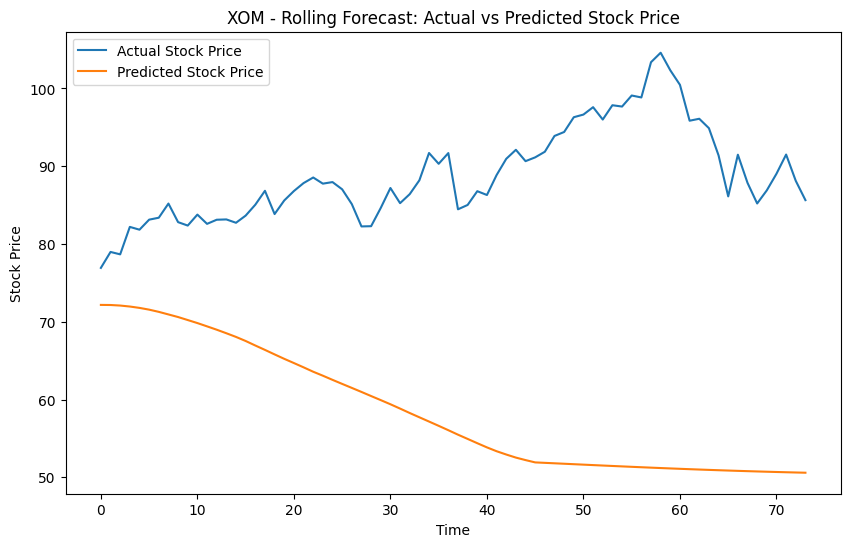


Processing ticker: SHW


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - SHW - Training Loss: 0.0094, Validation Loss: 0.0775
Epoch 2/150 - SHW - Training Loss: 0.0011, Validation Loss: 0.0417
Epoch 3/150 - SHW - Training Loss: 0.0279, Validation Loss: 0.0219
Epoch 4/150 - SHW - Training Loss: 0.1469, Validation Loss: 0.0474
Epoch 5/150 - SHW - Training Loss: 0.2342, Validation Loss: 0.0744
Epoch 6/150 - SHW - Training Loss: 0.2040, Validation Loss: 0.0617
Epoch 7/150 - SHW - Training Loss: 0.1906, Validation Loss: 0.0565
Epoch 8/150 - SHW - Training Loss: 0.1864, Validation Loss: 0.0548
Epoch 9/150 - SHW - Training Loss: 0.1833, Validation Loss: 0.0534
Epoch 10/150 - SHW - Training Loss: 0.1815, Validation Loss: 0.0524
Epoch 11/150 - SHW - Training Loss: 0.1803, Validation Loss: 0.0516
Epoch 12/150 - SHW - Training Loss: 0.1783, Validation Loss: 0.0509
Epoch 13/150 - SHW - Training Loss: 0.1766, Validation Loss: 0.0502
Early stopping triggered for SHW


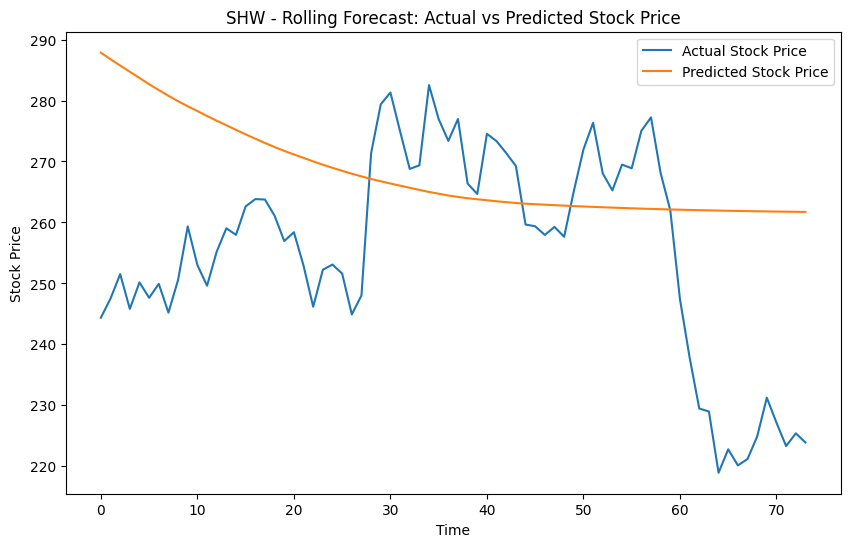


Processing ticker: AMZN


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMZN - Training Loss: 0.1998, Validation Loss: 0.1517
Epoch 2/150 - AMZN - Training Loss: 0.1010, Validation Loss: 0.0972
Epoch 3/150 - AMZN - Training Loss: 0.0097, Validation Loss: 0.0702
Epoch 4/150 - AMZN - Training Loss: 0.0438, Validation Loss: 0.1393
Epoch 5/150 - AMZN - Training Loss: 0.0198, Validation Loss: 0.1176
Epoch 6/150 - AMZN - Training Loss: 0.0266, Validation Loss: 0.1249
Epoch 7/150 - AMZN - Training Loss: 0.0241, Validation Loss: 0.1226
Epoch 8/150 - AMZN - Training Loss: 0.0224, Validation Loss: 0.1220
Epoch 9/150 - AMZN - Training Loss: 0.0225, Validation Loss: 0.1221
Epoch 10/150 - AMZN - Training Loss: 0.0225, Validation Loss: 0.1221
Epoch 11/150 - AMZN - Training Loss: 0.0224, Validation Loss: 0.1220
Epoch 12/150 - AMZN - Training Loss: 0.0215, Validation Loss: 0.1215
Epoch 13/150 - AMZN - Training Loss: 0.0214, Validation Loss: 0.1215
Early stopping triggered for AMZN


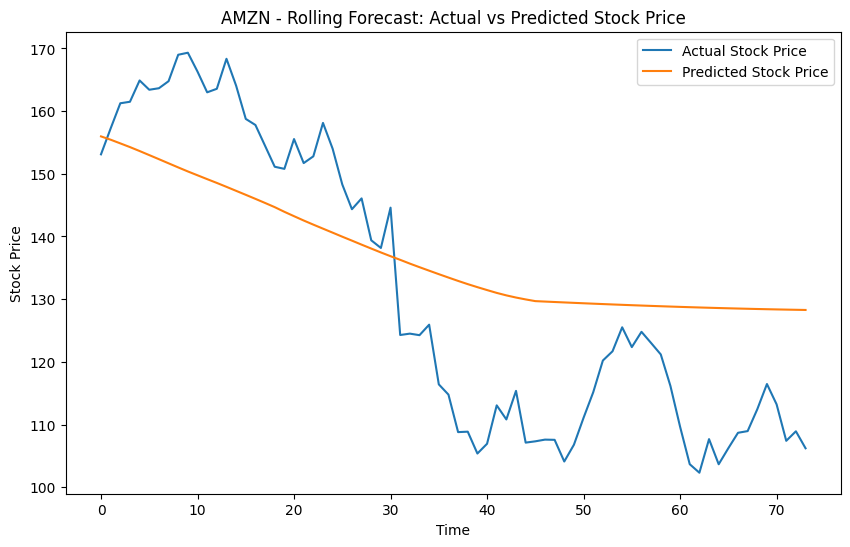


Processing ticker: PG


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - PG - Training Loss: 0.2476, Validation Loss: 0.3724
Epoch 2/150 - PG - Training Loss: 0.1326, Validation Loss: 0.2364
Epoch 3/150 - PG - Training Loss: 0.0321, Validation Loss: 0.1015
Epoch 4/150 - PG - Training Loss: 0.0160, Validation Loss: 0.0308
Epoch 5/150 - PG - Training Loss: 0.0267, Validation Loss: 0.0312
Epoch 6/150 - PG - Training Loss: 0.0211, Validation Loss: 0.0305
Epoch 7/150 - PG - Training Loss: 0.0271, Validation Loss: 0.0308
Epoch 8/150 - PG - Training Loss: 0.0331, Validation Loss: 0.0316
Epoch 9/150 - PG - Training Loss: 0.0363, Validation Loss: 0.0320
Epoch 10/150 - PG - Training Loss: 0.0409, Validation Loss: 0.0329
Epoch 11/150 - PG - Training Loss: 0.0422, Validation Loss: 0.0327
Epoch 12/150 - PG - Training Loss: 0.0416, Validation Loss: 0.0325
Epoch 13/150 - PG - Training Loss: 0.0430, Validation Loss: 0.0328
Epoch 14/150 - PG - Training Loss: 0.0453, Validation Loss: 0.0332
Epoch 15/150 - PG - Training Loss: 0.0462, Validation Loss: 0.0333
Epoc

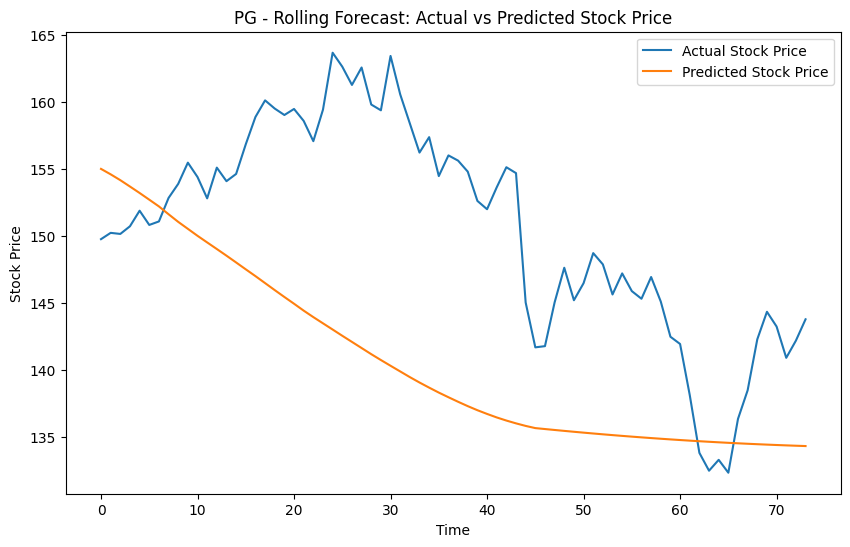


Processing ticker: JNJ


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JNJ - Training Loss: 0.3407, Validation Loss: 0.5090
Epoch 2/150 - JNJ - Training Loss: 0.2095, Validation Loss: 0.3283
Epoch 3/150 - JNJ - Training Loss: 0.0699, Validation Loss: 0.1236
Epoch 4/150 - JNJ - Training Loss: 0.0044, Validation Loss: 0.0194
Epoch 5/150 - JNJ - Training Loss: 0.0117, Validation Loss: 0.0379
Epoch 6/150 - JNJ - Training Loss: 0.0108, Validation Loss: 0.0351
Epoch 7/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0339
Epoch 8/150 - JNJ - Training Loss: 0.0105, Validation Loss: 0.0351
Epoch 9/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0341
Epoch 10/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0337
Epoch 11/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0340
Epoch 12/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0341
Epoch 13/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0340
Epoch 14/150 - JNJ - Training Loss: 0.0097, Validation Loss: 0.0338
Early stopping triggered for JNJ


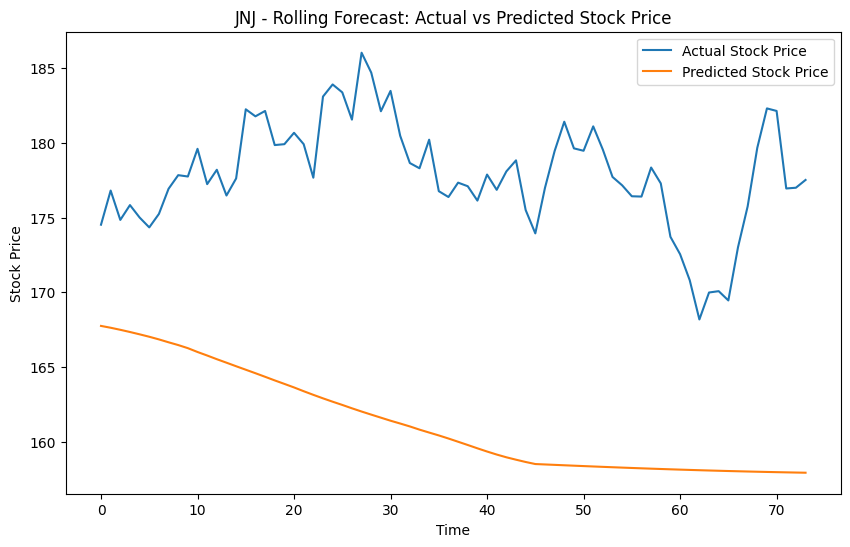


Processing ticker: JPM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JPM - Training Loss: 0.0702, Validation Loss: 0.0548
Epoch 2/150 - JPM - Training Loss: 0.0150, Validation Loss: 0.0235
Epoch 3/150 - JPM - Training Loss: 0.0174, Validation Loss: 0.0422
Epoch 4/150 - JPM - Training Loss: 0.2790, Validation Loss: 0.2088
Epoch 5/150 - JPM - Training Loss: 0.1707, Validation Loss: 0.1475
Epoch 6/150 - JPM - Training Loss: 0.1898, Validation Loss: 0.1613
Epoch 7/150 - JPM - Training Loss: 0.1765, Validation Loss: 0.1549
Epoch 8/150 - JPM - Training Loss: 0.1729, Validation Loss: 0.1527
Epoch 9/150 - JPM - Training Loss: 0.1736, Validation Loss: 0.1529
Epoch 10/150 - JPM - Training Loss: 0.1725, Validation Loss: 0.1520
Epoch 11/150 - JPM - Training Loss: 0.1683, Validation Loss: 0.1504
Epoch 12/150 - JPM - Training Loss: 0.1670, Validation Loss: 0.1494
Early stopping triggered for JPM


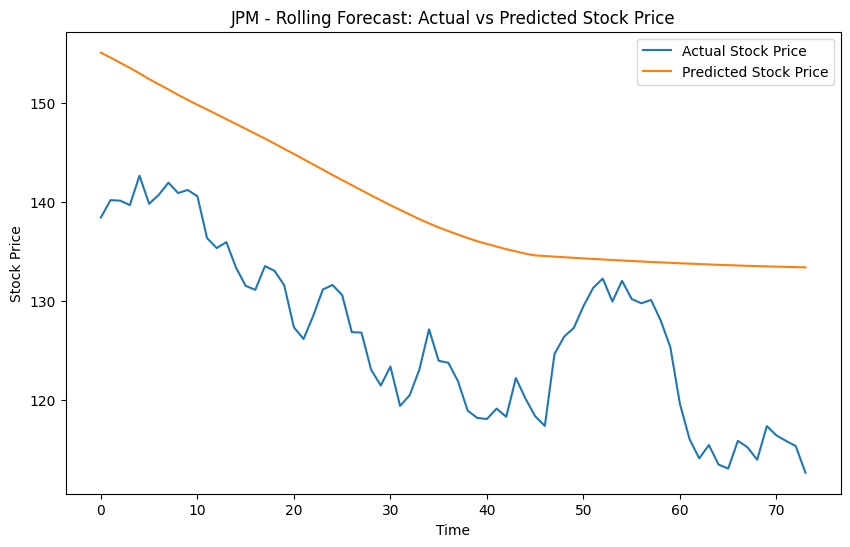


Processing ticker: AAPL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AAPL - Training Loss: 0.2856, Validation Loss: 0.2825
Epoch 2/150 - AAPL - Training Loss: 0.1603, Validation Loss: 0.1672
Epoch 3/150 - AAPL - Training Loss: 0.0491, Validation Loss: 0.0662
Epoch 4/150 - AAPL - Training Loss: 0.0030, Validation Loss: 0.0301
Epoch 5/150 - AAPL - Training Loss: 0.0048, Validation Loss: 0.0308
Epoch 6/150 - AAPL - Training Loss: 0.0040, Validation Loss: 0.0293
Epoch 7/150 - AAPL - Training Loss: 0.0061, Validation Loss: 0.0301
Epoch 8/150 - AAPL - Training Loss: 0.0091, Validation Loss: 0.0314
Epoch 9/150 - AAPL - Training Loss: 0.0118, Validation Loss: 0.0323
Epoch 10/150 - AAPL - Training Loss: 0.0151, Validation Loss: 0.0334
Epoch 11/150 - AAPL - Training Loss: 0.0163, Validation Loss: 0.0331
Epoch 12/150 - AAPL - Training Loss: 0.0162, Validation Loss: 0.0326
Epoch 13/150 - AAPL - Training Loss: 0.0175, Validation Loss: 0.0330
Epoch 14/150 - AAPL - Training Loss: 0.0190, Validation Loss: 0.0334
Epoch 15/150 - AAPL - Training Loss: 0.0195

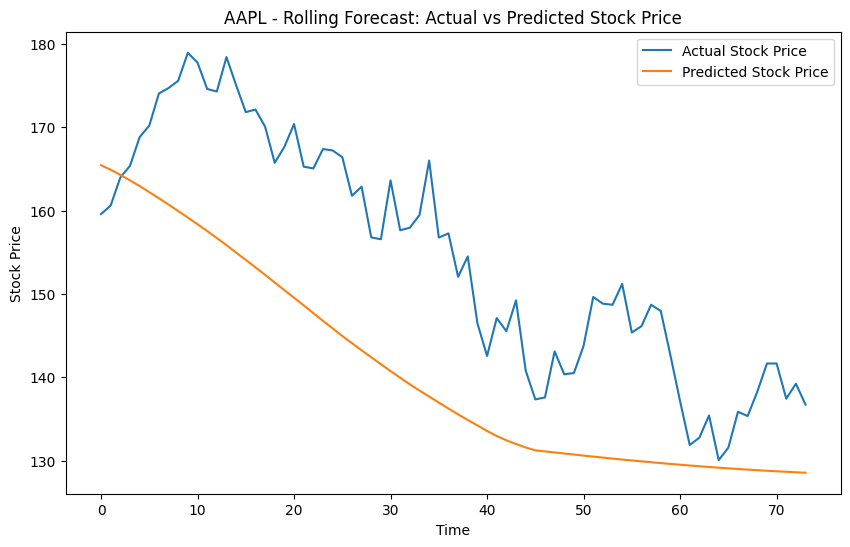


Processing ticker: GOOGL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - GOOGL - Training Loss: 0.3824, Validation Loss: 0.2567
Epoch 2/150 - GOOGL - Training Loss: 0.2316, Validation Loss: 0.1468
Epoch 3/150 - GOOGL - Training Loss: 0.0672, Validation Loss: 0.0404
Epoch 4/150 - GOOGL - Training Loss: 0.0412, Validation Loss: 0.0816
Epoch 5/150 - GOOGL - Training Loss: 0.0059, Validation Loss: 0.0404
Epoch 6/150 - GOOGL - Training Loss: 0.0114, Validation Loss: 0.0465
Epoch 7/150 - GOOGL - Training Loss: 0.0105, Validation Loss: 0.0438
Epoch 8/150 - GOOGL - Training Loss: 0.0114, Validation Loss: 0.0434
Epoch 9/150 - GOOGL - Training Loss: 0.0116, Validation Loss: 0.0424
Epoch 10/150 - GOOGL - Training Loss: 0.0085, Validation Loss: 0.0383
Epoch 11/150 - GOOGL - Training Loss: 0.0083, Validation Loss: 0.0378
Epoch 12/150 - GOOGL - Training Loss: 0.0090, Validation Loss: 0.0382
Epoch 13/150 - GOOGL - Training Loss: 0.0089, Validation Loss: 0.0376
Epoch 14/150 - GOOGL - Training Loss: 0.0090, Validation Loss: 0.0374
Epoch 15/150 - GOOGL - Traini

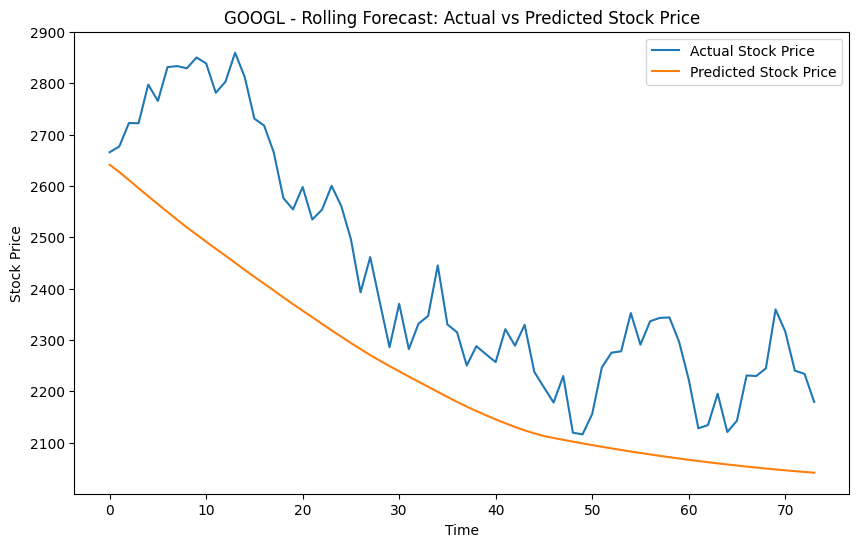


Processing ticker: NEE


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - NEE - Training Loss: 0.1918, Validation Loss: 0.1454
Epoch 2/150 - NEE - Training Loss: 0.1086, Validation Loss: 0.0921
Epoch 3/150 - NEE - Training Loss: 0.0332, Validation Loss: 0.0552
Epoch 4/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0668
Epoch 5/150 - NEE - Training Loss: 0.0022, Validation Loss: 0.0687
Epoch 6/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0640
Epoch 7/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0638
Epoch 8/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0638
Epoch 9/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0637
Epoch 10/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0635
Epoch 11/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0634
Epoch 12/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0634
Epoch 13/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0632
Early stopping triggered for NEE


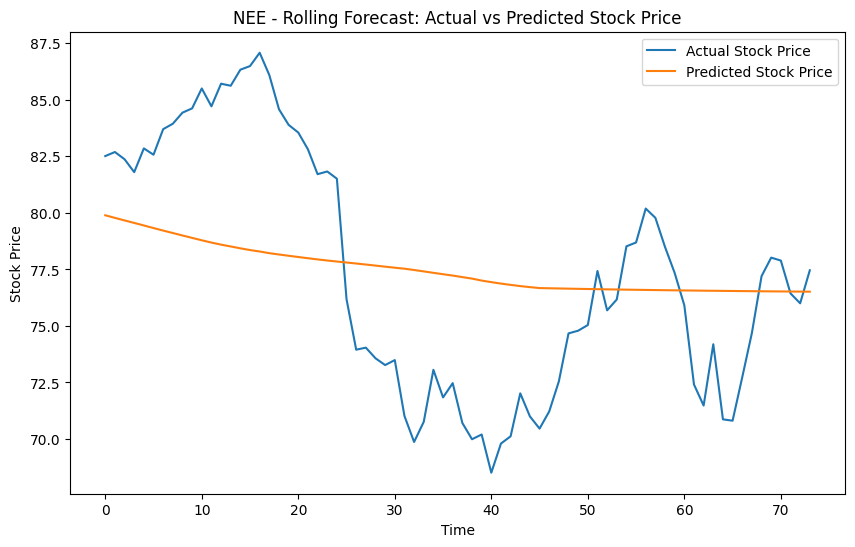


Processing ticker: AMT


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMT - Training Loss: 0.0813, Validation Loss: 0.2006
Epoch 2/150 - AMT - Training Loss: 0.0283, Validation Loss: 0.1152
Epoch 3/150 - AMT - Training Loss: 0.0004, Validation Loss: 0.0352
Epoch 4/150 - AMT - Training Loss: 0.0728, Validation Loss: 0.0216
Epoch 5/150 - AMT - Training Loss: 0.0580, Validation Loss: 0.0169
Epoch 6/150 - AMT - Training Loss: 0.0452, Validation Loss: 0.0151
Epoch 7/150 - AMT - Training Loss: 0.0491, Validation Loss: 0.0158
Epoch 8/150 - AMT - Training Loss: 0.0467, Validation Loss: 0.0155
Epoch 9/150 - AMT - Training Loss: 0.0446, Validation Loss: 0.0153
Epoch 10/150 - AMT - Training Loss: 0.0434, Validation Loss: 0.0152
Epoch 11/150 - AMT - Training Loss: 0.0398, Validation Loss: 0.0150
Epoch 12/150 - AMT - Training Loss: 0.0382, Validation Loss: 0.0149
Epoch 13/150 - AMT - Training Loss: 0.0378, Validation Loss: 0.0149
Epoch 14/150 - AMT - Training Loss: 0.0374, Validation Loss: 0.0149
Epoch 15/150 - AMT - Training Loss: 0.0369, Validation Lo

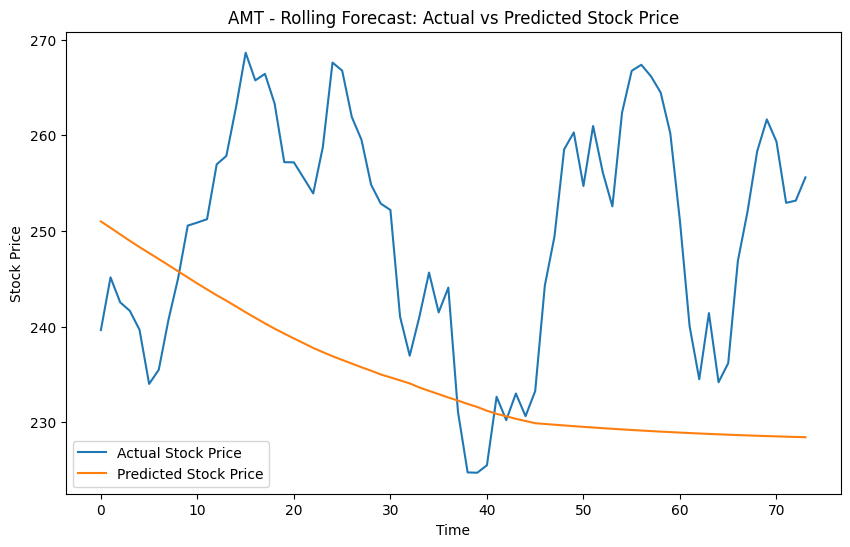

Ticker: XOM
Mean Squared Error (MSE): 1085.1610487481262
Root Mean Squared Error (RMSE): 32.94178271964233
Mean Absolute Percentage Error (MAPE): 33.34654011699128%


Ticker: SHW
Mean Squared Error (MSE): 510.9414357071832
Root Mean Squared Error (RMSE): 22.604013707905576
Mean Absolute Percentage Error (MAPE): 7.600768231539032%


Ticker: AMZN
Mean Squared Error (MSE): 253.89668422569196
Root Mean Squared Error (RMSE): 15.934135816720403
Mean Absolute Percentage Error (MAPE): 11.829360651246768%


Ticker: PG
Mean Squared Error (MSE): 150.0367622559592
Root Mean Squared Error (RMSE): 12.24894943478661
Mean Absolute Percentage Error (MAPE): 6.904558608264569%


Ticker: JNJ
Mean Squared Error (MSE): 295.38313857602367
Root Mean Squared Error (RMSE): 17.186714013330867
Mean Absolute Percentage Error (MAPE): 9.30059543256686%


Ticker: JPM
Mean Squared Error (MSE): 205.4325048920479
Root Mean Squared Error (RMSE): 14.332916831268083
Mean Absolute Percentage Error (MAPE): 10.868026144970765

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# List of tickers
tickers = ["XOM", "SHW", "AMZN", "PG", "JNJ", "JPM", "AAPL", "GOOGL", "NEE", "AMT"]

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Initialize results dictionary to store results for each company
results = {}

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Loop through each ticker and train an individual model
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")
    
    # Filter data for specific ticker
    data_filtered = data[data['Symbol'] == ticker]

    # Feature engineering
    data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
    data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
    data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()
    data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                                   'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                                   'Close_MA7', 'Close_MA30']].dropna()

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_filtered)

    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)

    # Split into train and validation sets
    split_index = int(len(X) * 0.8)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    # Initialize the model, loss function, and optimizer
    input_size = data_filtered.shape[1]
    model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping setup
    min_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            X_val_tensor = torch.from_numpy(X_val).float()
            y_val_tensor = torch.from_numpy(y_val).float()
            y_pred_val = model(X_val_tensor)
            val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
        
        print(f"Epoch {epoch+1}/{epochs} - {ticker} - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
        
        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print(f"Early stopping triggered for {ticker}")
                break

    # Rolling forecast on validation data
    model.eval()
    rolling_predictions = []
    current_sequence = X_val[0]  # Start with the first sequence in validation data

    with torch.no_grad():
        for i in range(len(X_val)):
            current_sequence_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0)
            prediction = model(current_sequence_tensor)
            rolling_predictions.append(prediction.item())

            # Update sequence by appending the prediction and removing the oldest element
            new_prediction = np.array([[prediction.item()] + [0] * (current_sequence.shape[1] - 1)])
            new_sequence = np.vstack((current_sequence[1:], new_prediction))
            current_sequence = new_sequence

    # Rescale and evaluate
    actual_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
    rolling_predictions_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([np.array(rolling_predictions).reshape(-1, 1), np.zeros((len(rolling_predictions), input_size - 1))], axis=1))[:, 0])

    # Calculate error metrics
    mse = mean_squared_error(actual_values_rescaled, rolling_predictions_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values_rescaled - rolling_predictions_rescaled) / actual_values_rescaled)) * 100

    # Store results for the ticker
    results[ticker] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Actual": actual_values_rescaled,
        "Predicted": rolling_predictions_rescaled
    }

    # Plot for each company
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values_rescaled, label='Actual Stock Price')
    plt.plot(rolling_predictions_rescaled, label='Predicted Stock Price')
    plt.title(f'{ticker} - Rolling Forecast: Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Print summary of results for each company
for ticker, metrics in results.items():
    print(f"Ticker: {ticker}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")
    print("\n")


One-time prediction applied on LSTM model for predictions of the 10 companies chosen


Processing ticker: XOM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - XOM - Training Loss: 0.4165, Validation Loss: 0.4946
Epoch 2/150 - XOM - Training Loss: 0.2592, Validation Loss: 0.3078
Epoch 3/150 - XOM - Training Loss: 0.0940, Validation Loss: 0.1076
Epoch 4/150 - XOM - Training Loss: 0.0214, Validation Loss: 0.0249
Epoch 5/150 - XOM - Training Loss: 0.0397, Validation Loss: 0.0483
Epoch 6/150 - XOM - Training Loss: 0.0344, Validation Loss: 0.0398
Epoch 7/150 - XOM - Training Loss: 0.0308, Validation Loss: 0.0352
Epoch 8/150 - XOM - Training Loss: 0.0305, Validation Loss: 0.0340
Epoch 9/150 - XOM - Training Loss: 0.0270, Validation Loss: 0.0314
Epoch 10/150 - XOM - Training Loss: 0.0261, Validation Loss: 0.0299
Epoch 11/150 - XOM - Training Loss: 0.0255, Validation Loss: 0.0288
Epoch 12/150 - XOM - Training Loss: 0.0248, Validation Loss: 0.0276
Epoch 13/150 - XOM - Training Loss: 0.0234, Validation Loss: 0.0267
Epoch 14/150 - XOM - Training Loss: 0.0229, Validation Loss: 0.0259
Early stopping triggered for XOM


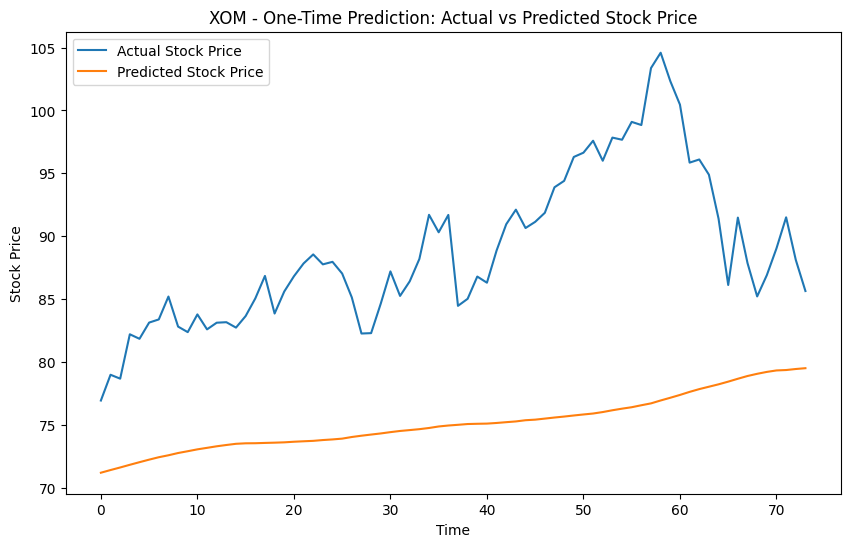


Processing ticker: SHW


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - SHW - Training Loss: 0.0083, Validation Loss: 0.0766
Epoch 2/150 - SHW - Training Loss: 0.0017, Validation Loss: 0.0403
Epoch 3/150 - SHW - Training Loss: 0.0346, Validation Loss: 0.0221
Epoch 4/150 - SHW - Training Loss: 0.1579, Validation Loss: 0.0486
Epoch 5/150 - SHW - Training Loss: 0.2373, Validation Loss: 0.0720
Epoch 6/150 - SHW - Training Loss: 0.2093, Validation Loss: 0.0607
Epoch 7/150 - SHW - Training Loss: 0.1962, Validation Loss: 0.0559
Epoch 8/150 - SHW - Training Loss: 0.1917, Validation Loss: 0.0543
Epoch 9/150 - SHW - Training Loss: 0.1885, Validation Loss: 0.0530
Epoch 10/150 - SHW - Training Loss: 0.1866, Validation Loss: 0.0520
Epoch 11/150 - SHW - Training Loss: 0.1854, Validation Loss: 0.0513
Epoch 12/150 - SHW - Training Loss: 0.1835, Validation Loss: 0.0507
Epoch 13/150 - SHW - Training Loss: 0.1818, Validation Loss: 0.0501
Early stopping triggered for SHW


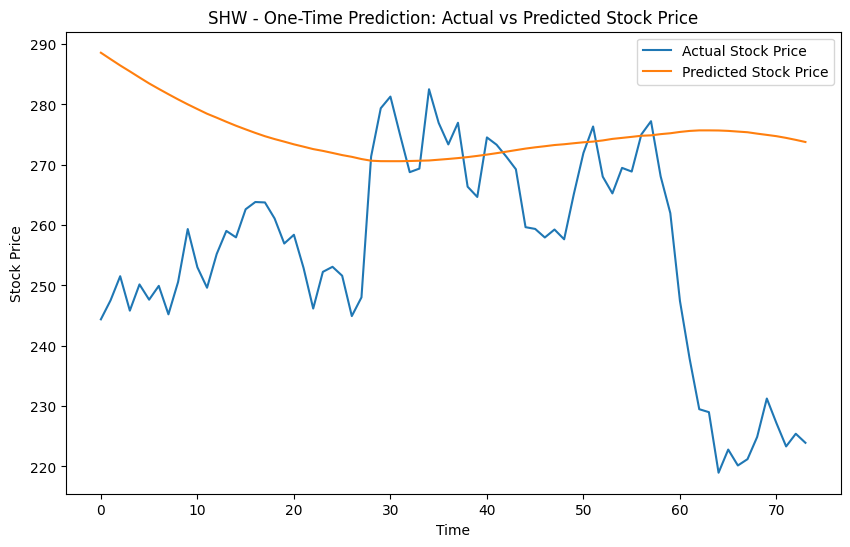


Processing ticker: AMZN


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMZN - Training Loss: 0.2518, Validation Loss: 0.1828
Epoch 2/150 - AMZN - Training Loss: 0.1390, Validation Loss: 0.1162
Epoch 3/150 - AMZN - Training Loss: 0.0197, Validation Loss: 0.0685
Epoch 4/150 - AMZN - Training Loss: 0.0364, Validation Loss: 0.1297
Epoch 5/150 - AMZN - Training Loss: 0.0228, Validation Loss: 0.1227
Epoch 6/150 - AMZN - Training Loss: 0.0260, Validation Loss: 0.1238
Epoch 7/150 - AMZN - Training Loss: 0.0263, Validation Loss: 0.1258
Epoch 8/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1232
Epoch 9/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1233
Epoch 10/150 - AMZN - Training Loss: 0.0232, Validation Loss: 0.1236
Epoch 11/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1234
Epoch 12/150 - AMZN - Training Loss: 0.0218, Validation Loss: 0.1226
Epoch 13/150 - AMZN - Training Loss: 0.0217, Validation Loss: 0.1225
Early stopping triggered for AMZN


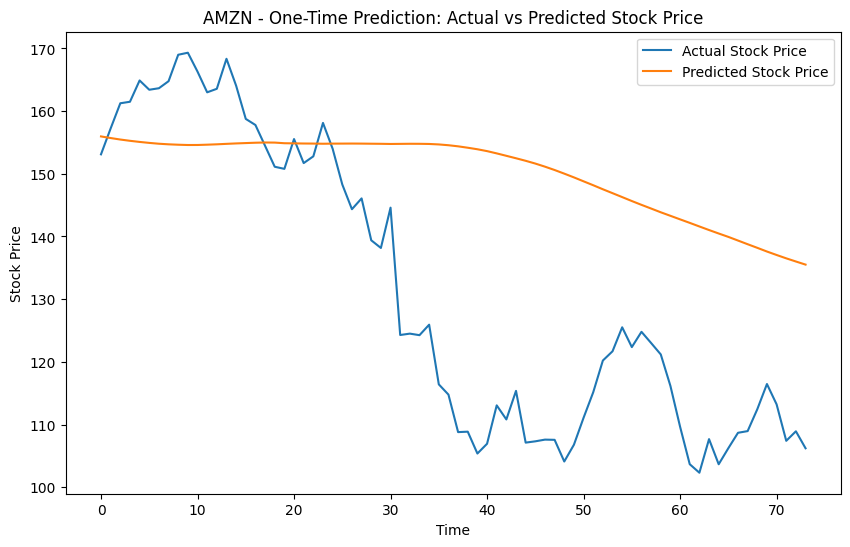


Processing ticker: PG


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - PG - Training Loss: 0.2558, Validation Loss: 0.3780
Epoch 2/150 - PG - Training Loss: 0.1389, Validation Loss: 0.2411
Epoch 3/150 - PG - Training Loss: 0.0361, Validation Loss: 0.1054
Epoch 4/150 - PG - Training Loss: 0.0140, Validation Loss: 0.0307
Epoch 5/150 - PG - Training Loss: 0.0286, Validation Loss: 0.0319
Epoch 6/150 - PG - Training Loss: 0.0216, Validation Loss: 0.0306
Epoch 7/150 - PG - Training Loss: 0.0273, Validation Loss: 0.0312
Epoch 8/150 - PG - Training Loss: 0.0333, Validation Loss: 0.0322
Epoch 9/150 - PG - Training Loss: 0.0363, Validation Loss: 0.0327
Epoch 10/150 - PG - Training Loss: 0.0406, Validation Loss: 0.0336
Epoch 11/150 - PG - Training Loss: 0.0418, Validation Loss: 0.0335
Epoch 12/150 - PG - Training Loss: 0.0412, Validation Loss: 0.0332
Epoch 13/150 - PG - Training Loss: 0.0425, Validation Loss: 0.0335
Epoch 14/150 - PG - Training Loss: 0.0446, Validation Loss: 0.0340
Epoch 15/150 - PG - Training Loss: 0.0455, Validation Loss: 0.0341
Epoc

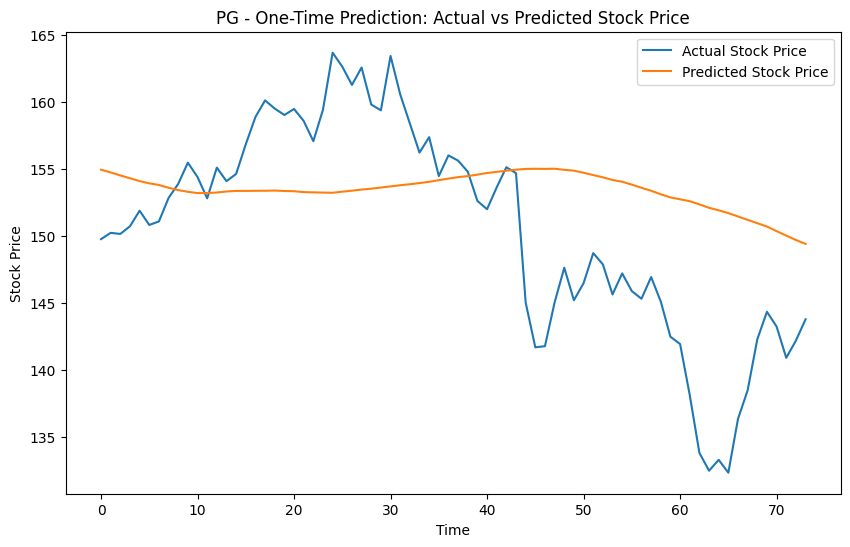


Processing ticker: JNJ


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JNJ - Training Loss: 0.3376, Validation Loss: 0.5100
Epoch 2/150 - JNJ - Training Loss: 0.2077, Validation Loss: 0.3317
Epoch 3/150 - JNJ - Training Loss: 0.0715, Validation Loss: 0.1318
Epoch 4/150 - JNJ - Training Loss: 0.0045, Validation Loss: 0.0213
Epoch 5/150 - JNJ - Training Loss: 0.0118, Validation Loss: 0.0413
Epoch 6/150 - JNJ - Training Loss: 0.0110, Validation Loss: 0.0384
Epoch 7/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0365
Epoch 8/150 - JNJ - Training Loss: 0.0106, Validation Loss: 0.0379
Epoch 9/150 - JNJ - Training Loss: 0.0101, Validation Loss: 0.0371
Epoch 10/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0367
Epoch 11/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0368
Epoch 12/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0369
Epoch 13/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0368
Epoch 14/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0367
Early stopping triggered for JNJ


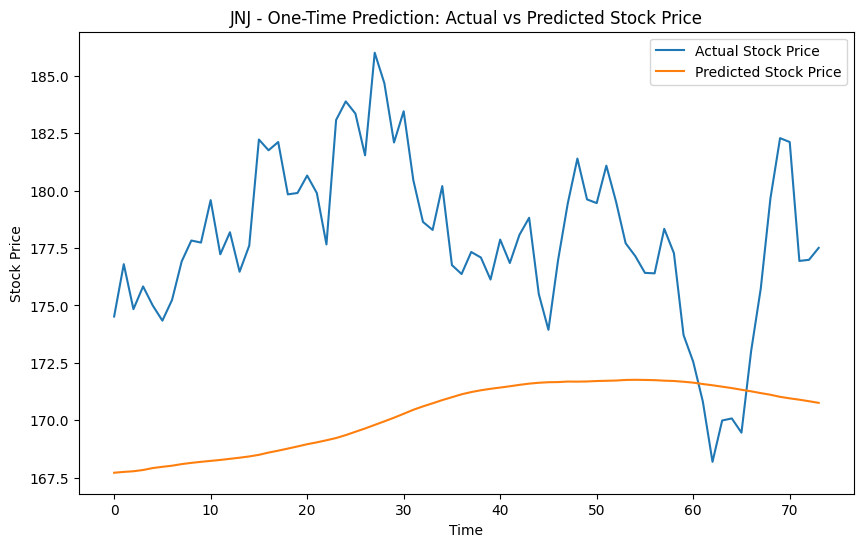


Processing ticker: JPM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JPM - Training Loss: 0.0768, Validation Loss: 0.0597
Epoch 2/150 - JPM - Training Loss: 0.0180, Validation Loss: 0.0249
Epoch 3/150 - JPM - Training Loss: 0.0160, Validation Loss: 0.0403
Epoch 4/150 - JPM - Training Loss: 0.2756, Validation Loss: 0.2049
Epoch 5/150 - JPM - Training Loss: 0.1684, Validation Loss: 0.1454
Epoch 6/150 - JPM - Training Loss: 0.1875, Validation Loss: 0.1586
Epoch 7/150 - JPM - Training Loss: 0.1725, Validation Loss: 0.1515
Epoch 8/150 - JPM - Training Loss: 0.1697, Validation Loss: 0.1498
Epoch 9/150 - JPM - Training Loss: 0.1702, Validation Loss: 0.1499
Epoch 10/150 - JPM - Training Loss: 0.1689, Validation Loss: 0.1487
Epoch 11/150 - JPM - Training Loss: 0.1644, Validation Loss: 0.1471
Epoch 12/150 - JPM - Training Loss: 0.1632, Validation Loss: 0.1461
Early stopping triggered for JPM


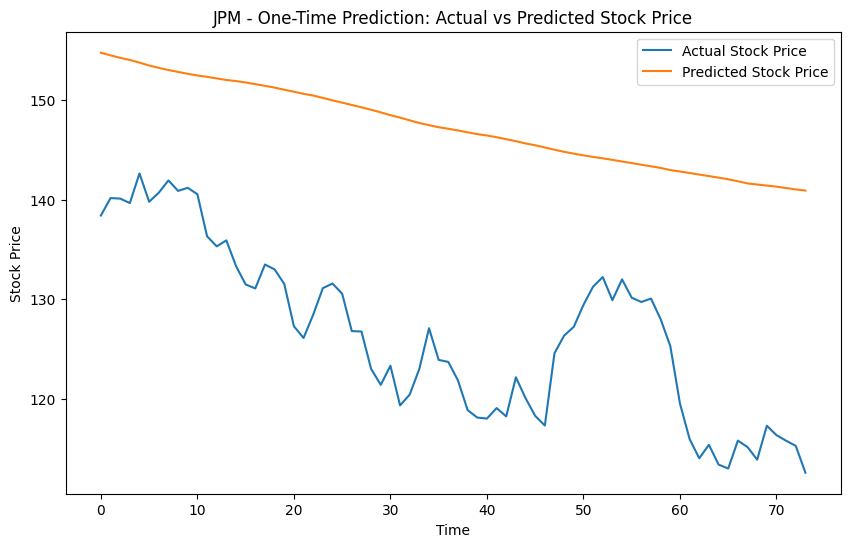


Processing ticker: AAPL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AAPL - Training Loss: 0.3374, Validation Loss: 0.3286
Epoch 2/150 - AAPL - Training Loss: 0.2002, Validation Loss: 0.2026
Epoch 3/150 - AAPL - Training Loss: 0.0674, Validation Loss: 0.0816
Epoch 4/150 - AAPL - Training Loss: 0.0031, Validation Loss: 0.0313
Epoch 5/150 - AAPL - Training Loss: 0.0050, Validation Loss: 0.0318
Epoch 6/150 - AAPL - Training Loss: 0.0040, Validation Loss: 0.0299
Epoch 7/150 - AAPL - Training Loss: 0.0067, Validation Loss: 0.0312
Epoch 8/150 - AAPL - Training Loss: 0.0098, Validation Loss: 0.0324
Epoch 9/150 - AAPL - Training Loss: 0.0125, Validation Loss: 0.0332
Epoch 10/150 - AAPL - Training Loss: 0.0159, Validation Loss: 0.0344
Epoch 11/150 - AAPL - Training Loss: 0.0170, Validation Loss: 0.0339
Epoch 12/150 - AAPL - Training Loss: 0.0168, Validation Loss: 0.0334
Epoch 13/150 - AAPL - Training Loss: 0.0182, Validation Loss: 0.0337
Epoch 14/150 - AAPL - Training Loss: 0.0197, Validation Loss: 0.0342
Epoch 15/150 - AAPL - Training Loss: 0.0202

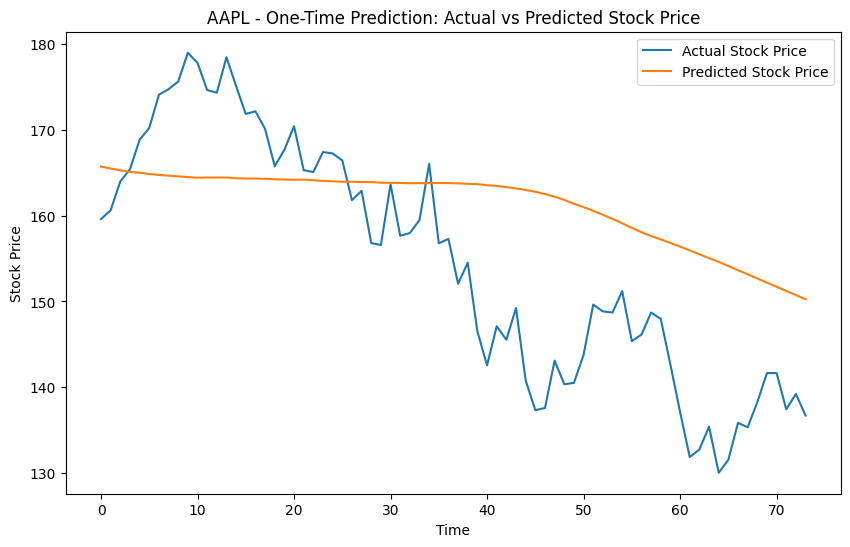


Processing ticker: GOOGL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - GOOGL - Training Loss: 0.4050, Validation Loss: 0.2757
Epoch 2/150 - GOOGL - Training Loss: 0.2514, Validation Loss: 0.1625
Epoch 3/150 - GOOGL - Training Loss: 0.0753, Validation Loss: 0.0455
Epoch 4/150 - GOOGL - Training Loss: 0.0494, Validation Loss: 0.0840
Epoch 5/150 - GOOGL - Training Loss: 0.0066, Validation Loss: 0.0398
Epoch 6/150 - GOOGL - Training Loss: 0.0131, Validation Loss: 0.0457
Epoch 7/150 - GOOGL - Training Loss: 0.0113, Validation Loss: 0.0426
Epoch 8/150 - GOOGL - Training Loss: 0.0125, Validation Loss: 0.0421
Epoch 9/150 - GOOGL - Training Loss: 0.0123, Validation Loss: 0.0410
Epoch 10/150 - GOOGL - Training Loss: 0.0091, Validation Loss: 0.0371
Epoch 11/150 - GOOGL - Training Loss: 0.0087, Validation Loss: 0.0365
Epoch 12/150 - GOOGL - Training Loss: 0.0095, Validation Loss: 0.0369
Epoch 13/150 - GOOGL - Training Loss: 0.0093, Validation Loss: 0.0363
Epoch 14/150 - GOOGL - Training Loss: 0.0094, Validation Loss: 0.0361
Epoch 15/150 - GOOGL - Traini

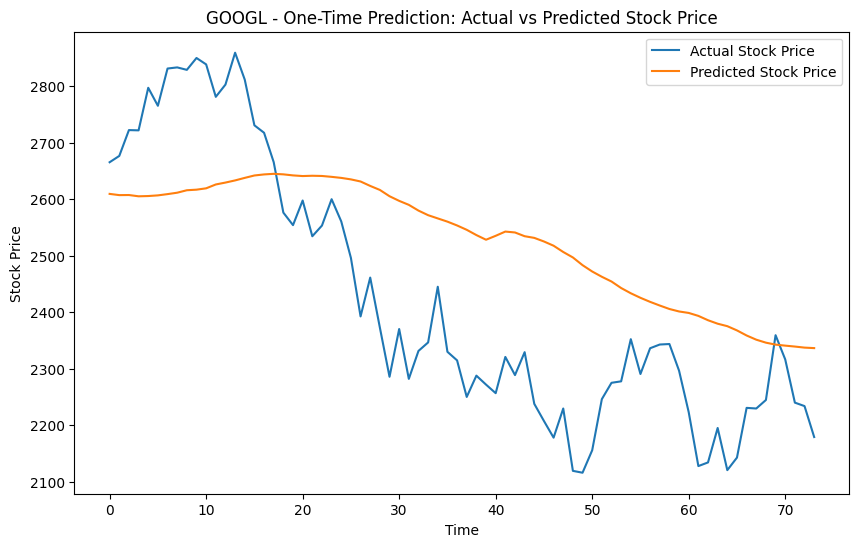


Processing ticker: NEE


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - NEE - Training Loss: 0.1545, Validation Loss: 0.1220
Epoch 2/150 - NEE - Training Loss: 0.0830, Validation Loss: 0.0785
Epoch 3/150 - NEE - Training Loss: 0.0243, Validation Loss: 0.0532
Epoch 4/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0630
Epoch 5/150 - NEE - Training Loss: 0.0020, Validation Loss: 0.0666
Epoch 6/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0632
Epoch 7/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0624
Epoch 8/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0623
Epoch 9/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0622
Epoch 10/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0621
Epoch 11/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0620
Epoch 12/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0619
Epoch 13/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0618
Early stopping triggered for NEE


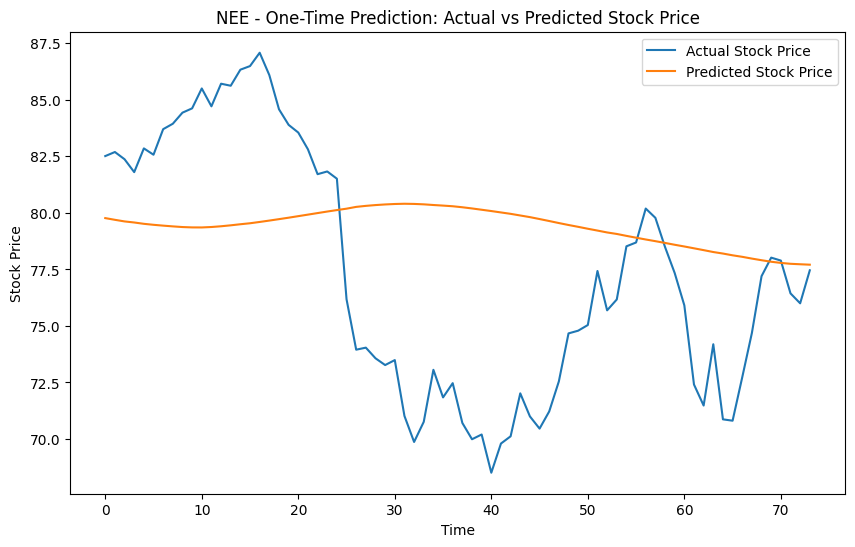


Processing ticker: AMT


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMT - Training Loss: 0.0937, Validation Loss: 0.2162
Epoch 2/150 - AMT - Training Loss: 0.0353, Validation Loss: 0.1252
Epoch 3/150 - AMT - Training Loss: 0.0003, Validation Loss: 0.0371
Epoch 4/150 - AMT - Training Loss: 0.0764, Validation Loss: 0.0243
Epoch 5/150 - AMT - Training Loss: 0.0514, Validation Loss: 0.0166
Epoch 6/150 - AMT - Training Loss: 0.0420, Validation Loss: 0.0154
Epoch 7/150 - AMT - Training Loss: 0.0465, Validation Loss: 0.0162
Epoch 8/150 - AMT - Training Loss: 0.0436, Validation Loss: 0.0158
Epoch 9/150 - AMT - Training Loss: 0.0418, Validation Loss: 0.0156
Epoch 10/150 - AMT - Training Loss: 0.0406, Validation Loss: 0.0156
Epoch 11/150 - AMT - Training Loss: 0.0366, Validation Loss: 0.0152
Epoch 12/150 - AMT - Training Loss: 0.0350, Validation Loss: 0.0151
Epoch 13/150 - AMT - Training Loss: 0.0346, Validation Loss: 0.0151
Epoch 14/150 - AMT - Training Loss: 0.0342, Validation Loss: 0.0152
Epoch 15/150 - AMT - Training Loss: 0.0337, Validation Lo

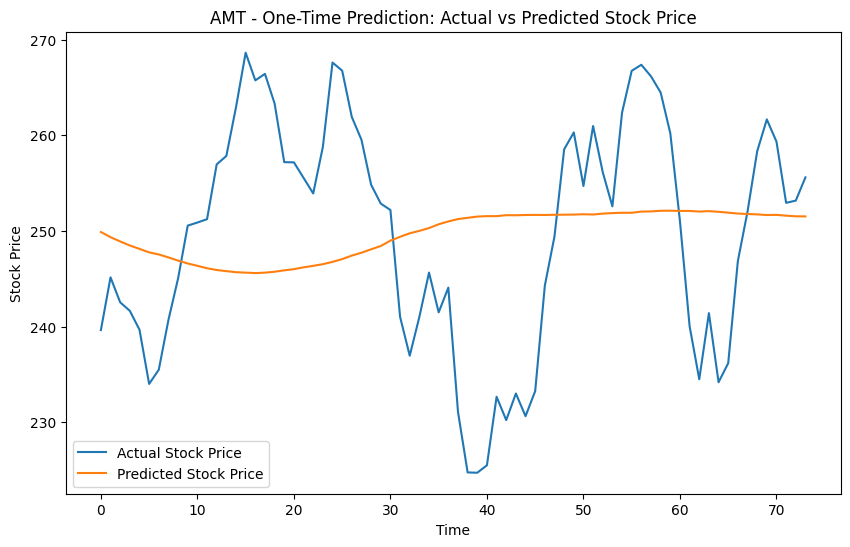

Ticker: XOM
Mean Squared Error (MSE): 213.47265533491597
Root Mean Squared Error (RMSE): 14.6107034510634
Mean Absolute Percentage Error (MAPE): 15.12426183820042%


Ticker: SHW
Mean Squared Error (MSE): 737.985744619682
Root Mean Squared Error (RMSE): 27.16589303924467
Mean Absolute Percentage Error (MAPE): 8.808748145999926%


Ticker: AMZN
Mean Squared Error (MSE): 739.8286569050649
Root Mean Squared Error (RMSE): 27.199791486426232
Mean Absolute Percentage Error (MAPE): 19.65794830503859%


Ticker: PG
Mean Squared Error (MSE): 64.79563348999915
Root Mean Squared Error (RMSE): 8.049573497397185
Mean Absolute Percentage Error (MAPE): 4.458812356836532%


Ticker: JNJ
Mean Squared Error (MSE): 74.7413903490968
Root Mean Squared Error (RMSE): 8.645310309589634
Mean Absolute Percentage Error (MAPE): 4.3838139010484545%


Ticker: JPM
Mean Squared Error (MSE): 466.71997038871507
Root Mean Squared Error (RMSE): 21.603702700896324
Mean Absolute Percentage Error (MAPE): 16.80445631822567%


Ti

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# List of tickers
tickers = ["XOM", "SHW", "AMZN", "PG", "JNJ", "JPM", "AAPL", "GOOGL", "NEE", "AMT"]

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Initialize results dictionary to store results for each company
results = {}

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Loop through each ticker and train an individual model
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")
    
    # Filter data for specific ticker
    data_filtered = data[data['Symbol'] == ticker]

    # Feature engineering
    data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
    data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
    data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()
    data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                                   'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                                   'Close_MA7', 'Close_MA30']].dropna()

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_filtered)

    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)

    # Split into train and validation sets
    split_index = int(len(X) * 0.8)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    # Initialize the model, loss function, and optimizer
    input_size = data_filtered.shape[1]
    model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping setup
    min_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            X_val_tensor = torch.from_numpy(X_val).float()
            y_val_tensor = torch.from_numpy(y_val).float()
            y_pred_val = model(X_val_tensor)
            val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
        
        print(f"Epoch {epoch+1}/{epochs} - {ticker} - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
        
        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print(f"Early stopping triggered for {ticker}")
                break

    # One-time prediction on the validation set
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_pred_val = model(X_val_tensor).squeeze().numpy()

    # Rescale and evaluate
    actual_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
    predicted_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_pred_val.reshape(-1, 1), np.zeros((len(y_pred_val), input_size - 1))], axis=1))[:, 0])

    # Calculate error metrics
    mse = mean_squared_error(actual_values_rescaled, predicted_values_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values_rescaled - predicted_values_rescaled) / actual_values_rescaled)) * 100

    # Store results for the ticker
    results[ticker] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Actual": actual_values_rescaled,
        "Predicted": predicted_values_rescaled
    }

    # Plot for each company
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values_rescaled, label='Actual Stock Price')
    plt.plot(predicted_values_rescaled, label='Predicted Stock Price')
    plt.title(f'{ticker} - One-Time Prediction: Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Print summary of results for each company
for ticker, metrics in results.items():
    print(f"Ticker: {ticker}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")
    print("\n")
